# **1. BUSINESS UNDERSTANDING**



Tesla dan BYD adalah dua perusahaan produsen mobil listrik *(electric vehicle)*. Meningkatnya minat terhadap penggunaan mobil listrik menjadi salah satu faktor yang mendorong peningkatan harga saham dari kedua perusahaan tersebut. Oleh karena itu, dengan melihat perusahaan Tesla dan BYD sebagai dua perusahaan dengan tingkat penjualan paling tinggi dan paling bersaing saat ini, maka prediksi harga saham menjadi hal yang dapat membantu investor maupun calon investor dalam membeli maupun menjual saham pada perusahaan tersebut.

Untuk melakukan prediksi harga saham, data yang akan digunakan sebagai indikator prediksi adalah harga penutupan saham harian. Harga penutupan saham (*Close Price*) yang akan digunakan dari perusahaan Tesla dan BYD diambil dari situs **Yahoo Finance**.

# **2. DATA UNDERSTANDING**

Pada tahap *Data Understanding* atau Pemahaman Data, kegiatan yang dilakukan mencakup mempersiapkan data, menilai kebutuhan data, dan mengumpulkan data. Persiapan data dilakukan dengan pengumpulan data dari berbagai sumber, kemudian memahami data yang tersedia untuk melihat kualitas data melalui analisis statistik dan pencarian atribut data.


## **Requirement**
Sebelum melakukan prediksi, langkah pertama yang perlu dilakukan adalah mengumpulkan kebutuhan pengolahan data berupa library yang akan digunakan serta data mentah dari kedua perusahaan.

In [1]:
# Import library yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE

from pandas_datareader.data import DataReader
import yfinance as yf

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Menetapkan waktu pengambilan data
start = '2015-05-31'
# end = '2025-05-31'
end = datetime.today().strftime('%Y-%m-%d') #Bagian ini dapat digunakan jika ingin mengambil data secara real time setiap harinya

# Menetapkan perusahaan dan kode perusahaan yang akan diprediksi
companies = ['Tesla', 'BYD']
companies_index = ['TSLA', 'BYDDY']

## **Collecting Data**
Pada bagian ini dilakukan pengambilan data yang berasal dari situs Yahoo Finance. Data yang diambil adalah data harga penutupan saham (*close price*) dari perusahaan Tesla dan BYD.

In [3]:
# Fungsi untuk mengambil data dari Yahoo Finance
def datasets_import(ticker, start, end):
  data = yf.Ticker(ticker).history(start=start, end=end)['Close']
  data = data.to_frame()
  data = data.reset_index()
  data.columns = ['Date', 'Close']
  data['Date'] = pd.to_datetime(data['Date']).dt.date

  return data

In [4]:
# Mengambil Data Tesla
tesla = datasets_import('TSLA', start, end)
print('Dataset Tesla\n')
tesla

Dataset Tesla



,Date,Close
0,2015-06-01,16.629999
1,2015-06-02,16.556667
2,2015-06-03,16.599333
3,2015-06-04,16.394667
4,2015-06-05,16.609333
...,...,...
2532,2025-06-25,327.549988
2533,2025-06-26,325.779999
2534,2025-06-27,323.630005
2535,2025-06-30,317.660004


In [5]:
# Mengambil Data Tesla dan BYD
byd = datasets_import('BYDDY', start, end)
print('Dataset BYD\n')
byd

Dataset BYD



,Date,Close
0,2015-06-01,13.019166
1,2015-06-02,13.114897
2,2015-06-03,13.038312
3,2015-06-04,14.340229
4,2015-06-05,13.028739
...,...,...
2532,2025-06-25,98.559998
2533,2025-06-26,95.720001
2534,2025-06-27,94.690002
2535,2025-06-30,93.800003


## **Exploratory Data Analysis**
Bagian ini mengeksplorasi data yang telah diambil secara lebih dalam untuk melihat kualitas dari data yang didapatkan.

In [6]:
# Mencetak informasi terkait dataset
print('Informasi Dataset Tesla')
tesla.info()
print('\nInformasi Dataset BYD')
byd.info()

Informasi Dataset Tesla
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2537 entries, 0 to 2536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2537 non-null   object 
 1   Close   2537 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.8+ KB

Informasi Dataset BYD
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2537 entries, 0 to 2536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2537 non-null   object 
 1   Close   2537 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.8+ KB


In [7]:
# Informasi statistik dataset
print('Informasi Statistik Dataset Tesla:')
print(tesla.describe())
print('\nInformasi Statistik Dataset BYD:')
print(byd.describe())

Informasi Statistik Dataset Tesla:
             Close
count  2537.000000
mean    129.516112
std     120.204380
min       9.578000
25%      18.604668
50%      64.056664
75%     234.960007
max     479.859985

Informasi Statistik Dataset BYD:
             Close
count  2537.000000
mean     35.631699
std      26.715770
min       7.083959
25%      11.607970
50%      18.471756
75%      58.869053
max     118.349998


In [8]:
# Ukuran dataset yang berupa (baris, kolom)
print('Ukuran dari Dataset Tesla: ', tesla.shape)
print('Ukuran dari Dataset BYD: ', byd.shape)

Ukuran dari Dataset Tesla:  (2537, 2)
Ukuran dari Dataset BYD:  (2537, 2)


In [9]:
# Mengunduh Dataset tesla dan byd
tesla.to_csv('tesla.csv')
byd.to_csv('byd.csv')

In [10]:
# Menggabungkan dataset Tesla dan BYD
df = pd.merge(tesla, byd, how='outer', on=['Date'])
df.columns = ['Date', 'Tesla', 'BYD']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Tesla,BYD
Date,,
2015-06-01,16.629999,13.019166
2015-06-02,16.556667,13.114897
2015-06-03,16.599333,13.038312
2015-06-04,16.394667,14.340229
2015-06-05,16.609333,13.028739
...,...,...
2025-06-25,327.549988,98.559998
2025-06-26,325.779999,95.720001
2025-06-27,323.630005,94.690002


In [11]:
# Proses konfirmasi dataset gabungan untuk memastikan informasi terkait dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2537 entries, 2015-06-01 to 2025-07-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tesla   2537 non-null   float64
 1   BYD     2537 non-null   float64
dtypes: float64(2)
memory usage: 59.5 KB


In [12]:
# Melihat keberadaan nilai null dari dataset 'df'
df.isnull().sum()

,0
Tesla,0
BYD,0


In [13]:
# Mencetak informasi statistik dari dataset 'df'
print('Informasi Statistik Dataset df \n')
df.describe()

Informasi Statistik Dataset df 



,Tesla,BYD
count,2537.000000,2537.000000
mean,129.516112,35.631699
std,120.204380,26.715770
min,9.578000,7.083959
25%,18.604668,11.607970
50%,64.056664,18.471756
75%,234.960007,58.869053
max,479.859985,118.349998


## **Data Visualization**
Setelah data didapatkan, selanjutnya adalah melakukan visualisasi data saham untuk melihat gambaran umum terkait pergerakan saham dari perusahaan Tesla dan BYD.

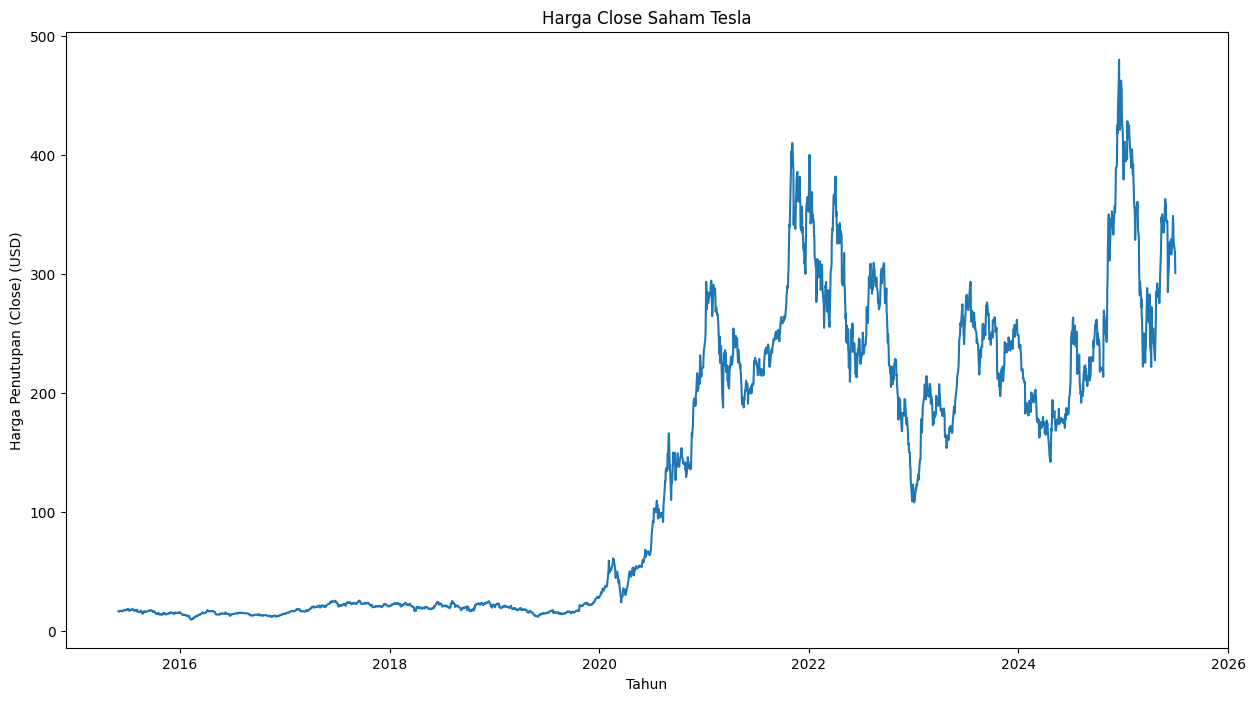

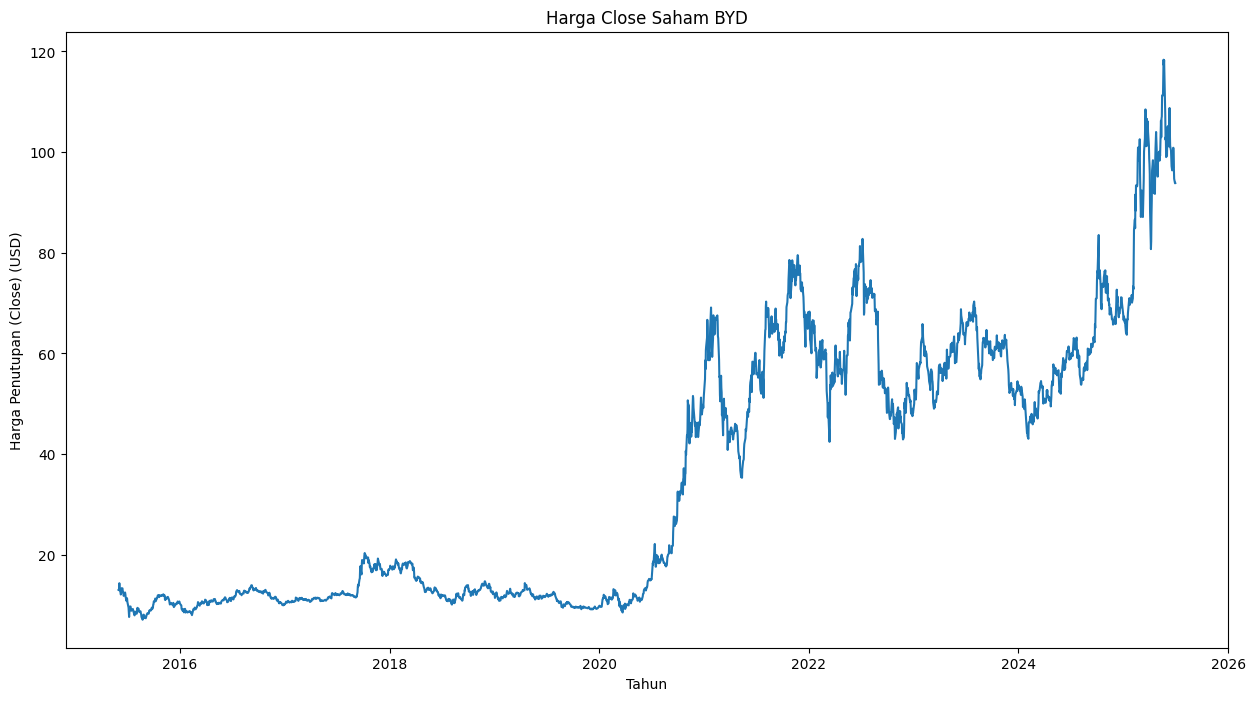

In [14]:
# Membuat grafik harga penutupan dari Tesla
plt.figure(figsize=(15, 8))
plt.plot(df['Tesla'], label='Tesla')
plt.title('Harga Close Saham Tesla')
plt.xlabel('Tahun')
plt.ylabel('Harga Penutupan (Close) (USD)')
plt.show()

# Membuat grafik harga penutupan dari BYD
plt.figure(figsize=(15, 8))
plt.plot(df['BYD'], label='BYD')
plt.title('Harga Close Saham BYD')
plt.xlabel('Tahun')
plt.ylabel('Harga Penutupan (Close) (USD)')
plt.show()


<Figure size 1800x1000 with 0 Axes>

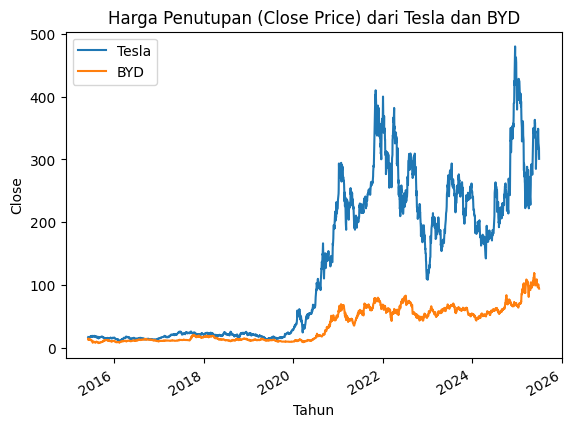

In [15]:
# Membuat grafik perbandingan harga Close dari Tesla dan BYD
plt.figure(figsize=(18, 10))
df.plot()
plt.ylabel('Close')
plt.xlabel('Tahun')
plt.title(f"Harga Penutupan (Close Price) dari Tesla dan BYD")

plt.show()

# **3. DATA PREPARATION**


Tahap *Data Preparation* adalah tahap untuk mengidentifikasi data, menyeleksi, dan melakukan pembersihan data untuk selanjutnya disusun ke dalam format yang dibutuhkan.

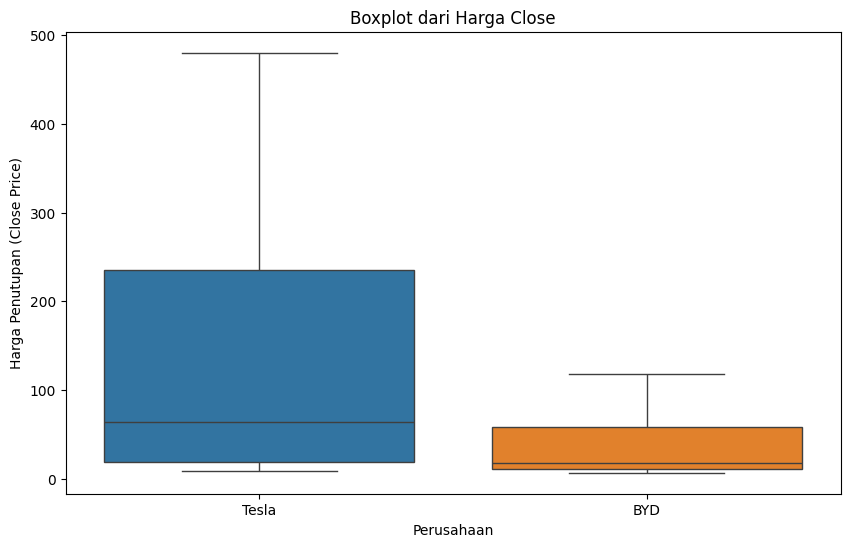

In [16]:
# Pengecekan Outlier dengan menggunakan boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Boxplot dari Harga Close')
plt.xlabel('Perusahaan')
plt.ylabel('Harga Penutupan (Close Price)')
plt.show()

### **3.1. Menghitung Moving Average**
*Moving Average* adalah salah satu indikator yang dapat membantu dalam menganalisis pergerakan saham. Pada bagian ini, dilakukan penyalinan dataset 'df' terlebih dahulu sebelum dilakukan perhitungan. Bagian ini bertujuan untuk memberikan gambaran terkait pergerakan saham secara umum.


In [17]:
# Membuat salinan dataset
df_ma = df.copy()

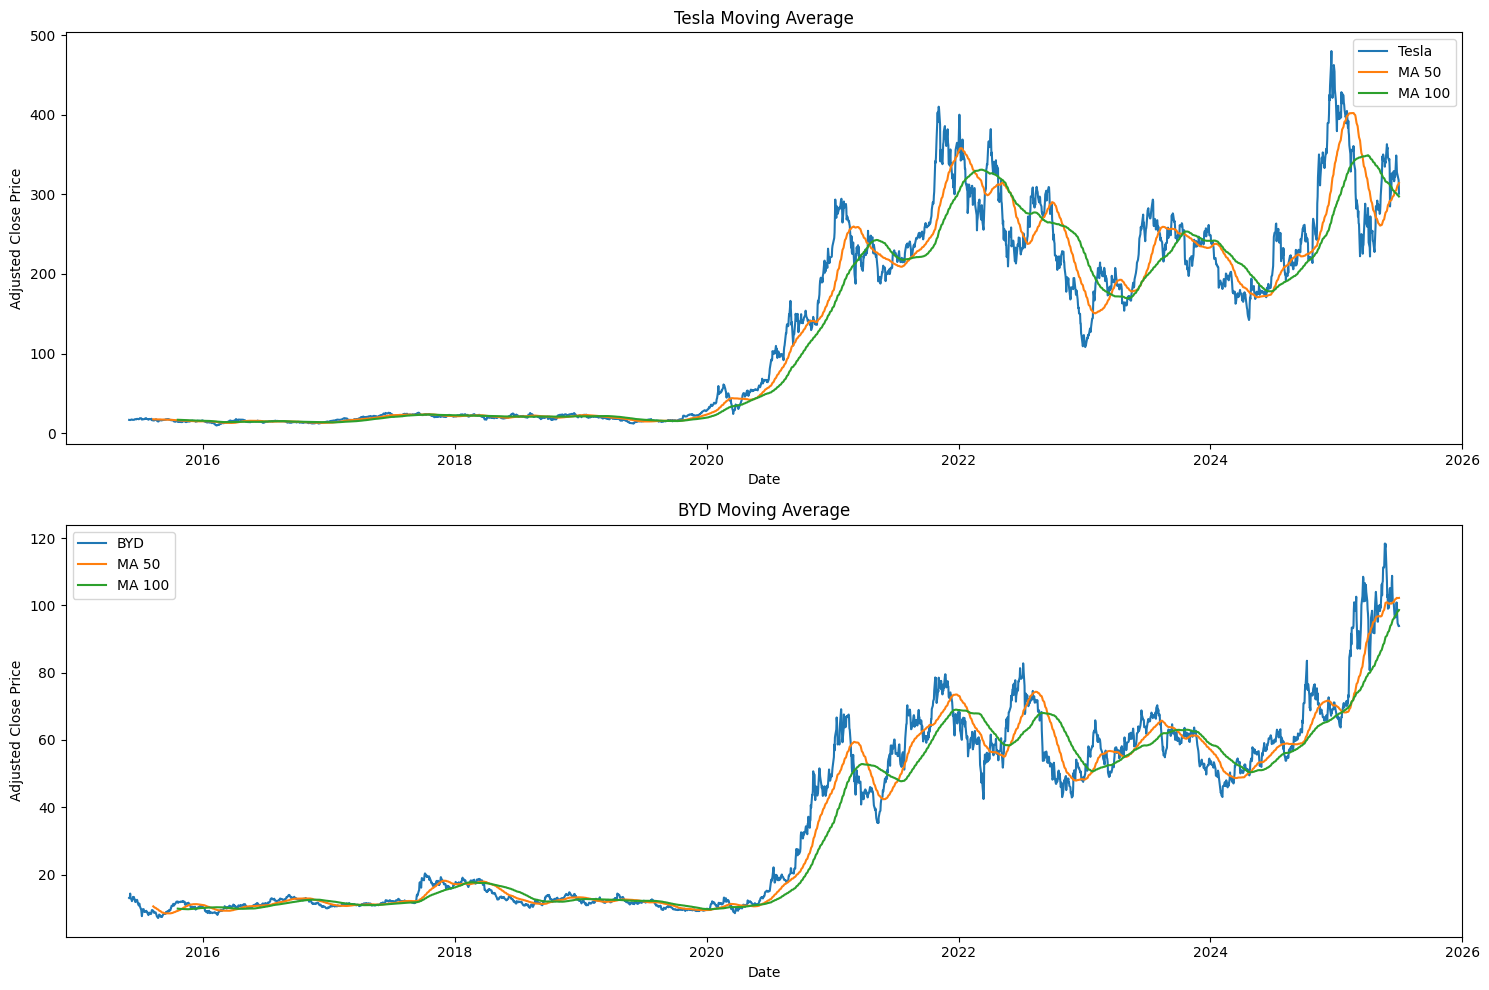

Bentuk dari dataset df_ma adalah:  (2537, 6)


,0
Tesla,0
BYD,0
Tesla_MA50,49
BYD_MA50,49
Tesla_MA100,99
BYD_MA100,99


In [18]:
# Menghitung Moving Average
ma_day = [50, 100]

for ma in ma_day:
    for company in companies:
        df_ma[f"{company}_MA{ma}"] = df_ma[company].rolling(ma).mean()

# Membuat grafik Moving Average
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Tentukan fungsi untuk membuat plot
def plot_moving_averages(ax, company):
    ax.plot(df_ma[company], label=company)
    for ma in ma_day:
        ax.plot(df_ma[f"{company}_MA{ma}"], label=f'MA {ma}')
    ax.set_title(f'{company} Moving Average')
    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted Close Price')
    ax.legend()

# Gunakan loop untuk membuat grafik dari setiap perusahaan
for i, company in enumerate(companies):
    plot_moving_averages(axes[i], company)

plt.tight_layout()
plt.show()

# Mencetak informasi nilai null dari dataset
print('Bentuk dari dataset df_ma adalah: ', df_ma.shape)
df_ma.isnull().sum()

In [19]:
# Menangani nilai null dengan melakukan penghapusan data
df_ma.dropna(inplace=True)
print('Bentuk dari dataset df_2 setelah dilakukan penghapusan adalah: ', df_ma.shape)

Bentuk dari dataset df_2 setelah dilakukan penghapusan adalah:  (2438, 6)


In [20]:
# Menampilkan informasi dari dataset 'df_ma'
df_ma.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2438 entries, 2015-10-20 to 2025-07-01
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tesla        2438 non-null   float64
 1   BYD          2438 non-null   float64
 2   Tesla_MA50   2438 non-null   float64
 3   BYD_MA50     2438 non-null   float64
 4   Tesla_MA100  2438 non-null   float64
 5   BYD_MA100    2438 non-null   float64
dtypes: float64(6)
memory usage: 133.3 KB


In [21]:
# Mencetak dataset 'df_ma' secara lebih rinci
df_ma

,Tesla,BYD,Tesla_MA50,BYD_MA50,Tesla_MA100,BYD_MA100
Date,,,,,,
2015-10-20,14.202000,11.822552,16.154667,9.194595,16.774273,9.867666
2015-10-21,14.006000,11.573655,16.118293,9.249160,16.748033,9.853211
2015-10-22,14.114667,11.889562,16.083026,9.313873,16.723613,9.840958
2015-10-23,13.939333,11.879989,16.038466,9.374757,16.697013,9.829375
2015-10-26,14.350667,11.812979,16.001280,9.435258,16.676573,9.804102
...,...,...,...,...,...,...
2025-06-25,327.549988,98.559998,308.440800,102.224600,300.120500,97.691100
2025-06-26,325.779999,95.720001,309.909400,102.171400,299.332300,97.947500
2025-06-27,323.630005,94.690002,311.299800,102.137800,298.731800,98.185200


In [22]:
# Memastikan keberadaan nilai null kembali setelah penghapusan nilai null
df_ma.isnull().sum()

,0
Tesla,0
BYD,0
Tesla_MA50,0
BYD_MA50,0
Tesla_MA100,0
BYD_MA100,0


### **3.2. Data Cleaning**
*Outlier* adalah data pencilan yang berbeda dari mayoritas data. Pengecekan diperlukan karena keberadaan *outlier* dapat mempengaruhi pengolahan data dan prediksi.

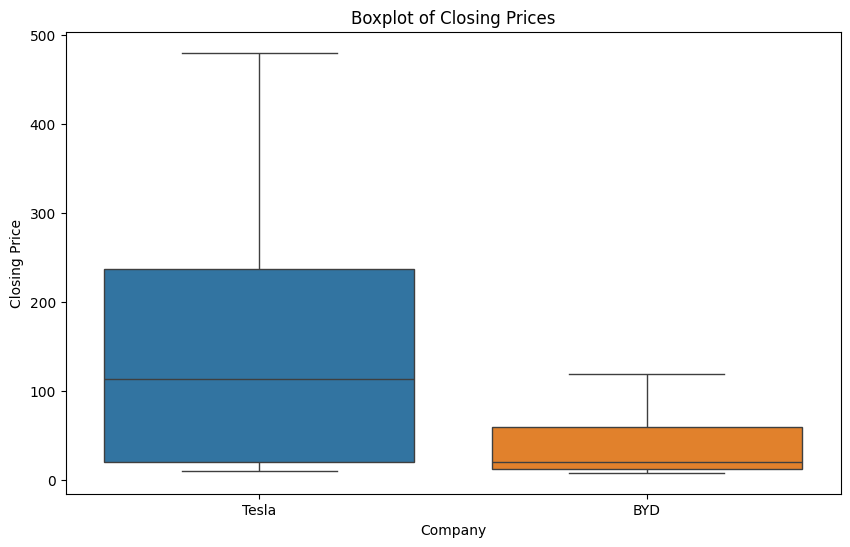

In [23]:
# Pengecekan Outlier dengan menggunakan boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_ma[['Tesla', 'BYD']])
plt.title('Boxplot of Closing Prices')
plt.xlabel('Company')
plt.ylabel('Closing Price')
plt.show()

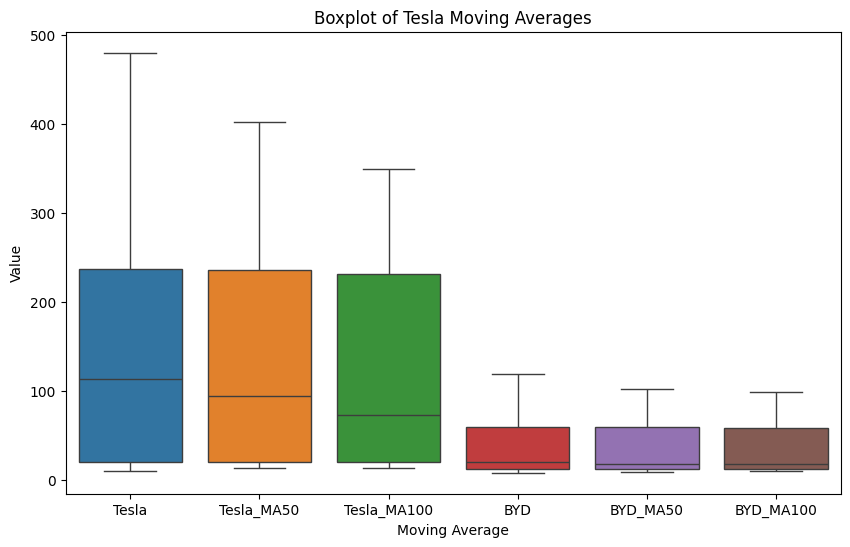

In [24]:
# Pengecekan Outlier dengan menggunakan boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_ma[['Tesla', 'Tesla_MA50', 'Tesla_MA100',
                        'BYD', 'BYD_MA50', 'BYD_MA100']])
plt.title('Boxplot of Tesla Moving Averages')
plt.xlabel('Moving Average')
plt.ylabel('Value')
plt.show()

In [25]:
# BAGIAN INI HANYA DIGUNAKAN UNTUK MENGATASI OUTLIER
"""# Menghitung IQR
Q1 = df_ma['Tesla'].quantile(0.25)
Q3 = df_ma['Tesla'].quantile(0.75)
IQR = Q3 - Q1

# Menentukan batas atas dan bawah
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR"""

"# Menghitung IQR\nQ1 = df_ma['Tesla'].quantile(0.25)\nQ3 = df_ma['Tesla'].quantile(0.75)\nIQR = Q3 - Q1\n\n# Menentukan batas atas dan bawah\nupper_bound = Q3 + 1.5 * IQR\nlower_bound = Q1 - 1.5 * IQR"

In [26]:
"""# Mencari baris dengan nilai outlier
outliers = df_ma[
    (df_ma['Tesla'] < lower_bound) | (df_ma['Tesla'] > upper_bound)]

outliers"""

"# Mencari baris dengan nilai outlier\noutliers = df_ma[\n    (df_ma['Tesla'] < lower_bound) | (df_ma['Tesla'] > upper_bound)]\n\noutliers"

In [27]:
"""# Mengganti outlier dengan nilai median
median_value = df_ma['Tesla'].median()
df_ma['Tesla'] = np.where((df_ma['Tesla'] < lower_bound) | (df_ma['Tesla'] > upper_bound),
                            median_value, df_ma['Tesla'])"""

"# Mengganti outlier dengan nilai median\nmedian_value = df_ma['Tesla'].median()\ndf_ma['Tesla'] = np.where((df_ma['Tesla'] < lower_bound) | (df_ma['Tesla'] > upper_bound),\n                            median_value, df_ma['Tesla'])"

In [28]:
"""# Pengecekan Outlier dengan menggunakan boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_ma[['Tesla', 'Tesla_MA50', 'Tesla_MA100']])
plt.title('Boxplot of Tesla Moving Averages')
plt.xlabel('Moving Average')
plt.ylabel('Value')
plt.show()"""

"# Pengecekan Outlier dengan menggunakan boxplot\nplt.figure(figsize=(10, 6))\nsns.boxplot(data=df_ma[['Tesla', 'Tesla_MA50', 'Tesla_MA100']])\nplt.title('Boxplot of Tesla Moving Averages')\nplt.xlabel('Moving Average')\nplt.ylabel('Value')\nplt.show()"

In [29]:
"""# Assuming 'outliers' DataFrame has an index that matches the index of 'df_ma'
df_ma.loc[outliers.index]"""

"# Assuming 'outliers' DataFrame has an index that matches the index of 'df_ma'\ndf_ma.loc[outliers.index]"

In [30]:
df_ma

,Tesla,BYD,Tesla_MA50,BYD_MA50,Tesla_MA100,BYD_MA100
Date,,,,,,
2015-10-20,14.202000,11.822552,16.154667,9.194595,16.774273,9.867666
2015-10-21,14.006000,11.573655,16.118293,9.249160,16.748033,9.853211
2015-10-22,14.114667,11.889562,16.083026,9.313873,16.723613,9.840958
2015-10-23,13.939333,11.879989,16.038466,9.374757,16.697013,9.829375
2015-10-26,14.350667,11.812979,16.001280,9.435258,16.676573,9.804102
...,...,...,...,...,...,...
2025-06-25,327.549988,98.559998,308.440800,102.224600,300.120500,97.691100
2025-06-26,325.779999,95.720001,309.909400,102.171400,299.332300,97.947500
2025-06-27,323.630005,94.690002,311.299800,102.137800,298.731800,98.185200


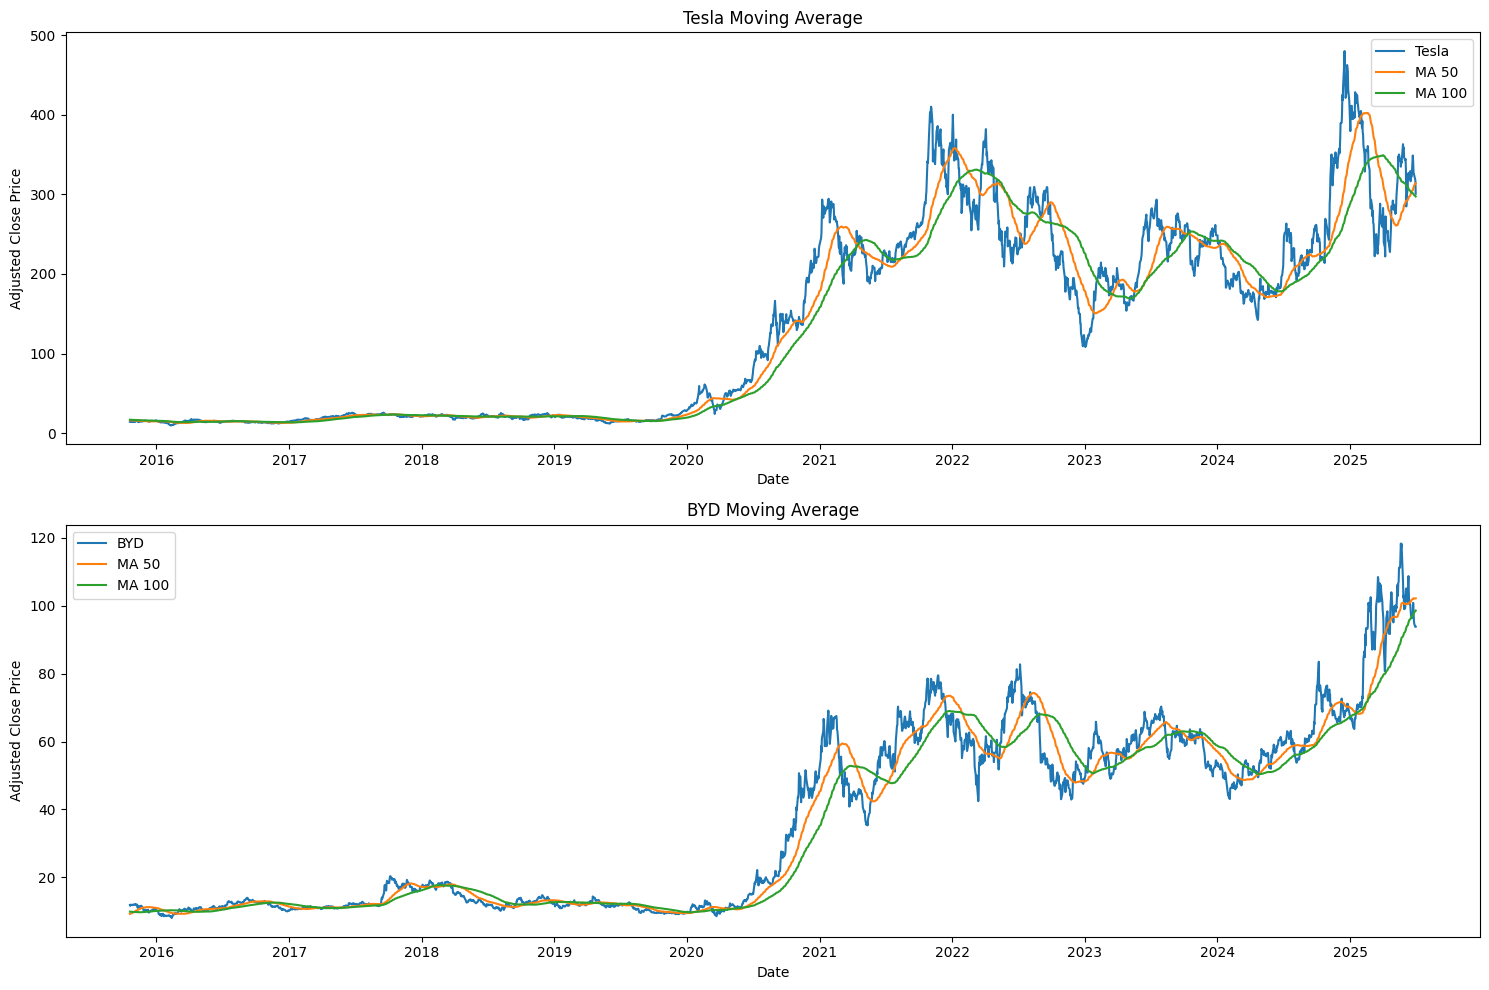

In [31]:
# Membuat grafik Moving Average terbaru
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Tentukan fungsi untuk membuat plot
def plot_moving_averages(ax, company):
    ax.plot(df_ma[company], label=company)
    for ma in ma_day:
        ax.plot(df_ma[f"{company}_MA{ma}"], label=f'MA {ma}')
    ax.set_title(f'{company} Moving Average')
    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted Close Price')
    ax.legend()

# Gunakan loop untuk membuat grafik dari setiap perusahaan
for i, company in enumerate(companies):
    plot_moving_averages(axes[i], company)

plt.tight_layout()
plt.show()

### **3.3. Persiapan Membuat Model LSTM**
Untuk pengolahan data lebih lanjut, dilakukan penyalinan dataset emnjadi 'df_2' untuk memastikan integritas dari data asli tetap terjaga pada dataset 'df'.

In [32]:
# Bagian ini, df_2 menggunakan data asli dari dataset yang tidak memiliki hasil perhitungan moving average
# Membuat salinan database 'df'
df_2 = df.copy()

In [33]:
# Mencetak kembali dataset df_2
df_2

,Tesla,BYD
Date,,
2015-06-01,16.629999,13.019166
2015-06-02,16.556667,13.114897
2015-06-03,16.599333,13.038312
2015-06-04,16.394667,14.340229
2015-06-05,16.609333,13.028739
...,...,...
2025-06-25,327.549988,98.559998
2025-06-26,325.779999,95.720001
2025-06-27,323.630005,94.690002


In [34]:
# Menyalin kembali dataset
df_3 = df_2.copy()
df_3 = df_3.filter(['Date', 'Tesla', 'BYD'])
df_3

,Tesla,BYD
Date,,
2015-06-01,16.629999,13.019166
2015-06-02,16.556667,13.114897
2015-06-03,16.599333,13.038312
2015-06-04,16.394667,14.340229
2015-06-05,16.609333,13.028739
...,...,...
2025-06-25,327.549988,98.559998
2025-06-26,325.779999,95.720001
2025-06-27,323.630005,94.690002


# **4. DATA MODELLING**

## **4.1. Scaling & Normalisasi Data**
Scaling adalah tahap normalisasi untuk mengonversi nilai dari variabel independen ke dalam rentang 0 sampai 1. Teknik ini berfungsi untuk menyeimbangkan nilai data.

In [35]:
# Scale dataset 'Adj Close'
scale_tesla = MinMaxScaler(feature_range=(0,1))
df_3[['scaled_tesla']]= scale_tesla.fit_transform(df_3[['Tesla']])
np.set_printoptions(threshold=np.inf)

scale_byd = MinMaxScaler(feature_range=(0,1))
df_3[['scaled_byd']]= scale_byd.fit_transform(df_3[['BYD']])
np.set_printoptions(threshold=np.inf)

In [36]:
print(df_3)

                 Tesla        BYD  scaled_tesla  scaled_byd
Date                                                       
2015-06-01   16.629999  13.019166      0.014995    0.053342
2015-06-02   16.556667  13.114897      0.014839    0.054203
2015-06-03   16.599333  13.038312      0.014930    0.053515
2015-06-04   16.394667  14.340229      0.014495    0.065215
2015-06-05   16.609333  13.028739      0.014951    0.053429
...                ...        ...           ...         ...
2025-06-25  327.549988  98.559998      0.676130    0.822138
2025-06-26  325.779999  95.720001      0.672367    0.796614
2025-06-27  323.630005  94.690002      0.667795    0.787357
2025-06-30  317.660004  93.800003      0.655101    0.779358
2025-07-01  300.709991  93.839996      0.619058    0.779717

[2537 rows x 4 columns]


In [37]:
# Menghitung nilai minimum dan maksimum
min_tesla = df_3['Tesla'].min()
max_tesla = df_3['Tesla'].max()
min_scaled_tesla = df_3['scaled_tesla'].min()
max_scaled_tesla = df_3['scaled_tesla'].max()

print(f"Rentang data aktual 'Close' Tesla: {min_tesla} sampai {max_tesla}")
print(f"Rentang data hasil scaling 'scaled_tesla': {min_scaled_tesla} sampai {max_scaled_tesla}")

# Menghitung nilai minimum dan maksimum
min_byd = df_3['BYD'].min()
max_byd = df_3['BYD'].max()
min_scaled_byd = df_3['scaled_byd'].min()
max_scaled_byd = df_3['scaled_byd'].max()

print(f"\nRentang data aktual 'Close': {min_byd} sampai {max_byd}")
print(f"Rentang data hasil scaling 'scaled_byd': {min_scaled_byd} sampai {max_scaled_byd}")

Rentang data aktual 'Close' Tesla: 9.57800006866455 sampai 479.8599853515625
Rentang data hasil scaling 'scaled_tesla': 0.0 sampai 1.0

Rentang data aktual 'Close': 7.083958625793457 sampai 118.3499984741211
Rentang data hasil scaling 'scaled_byd': 0.0 sampai 0.9999999999999999


## **4.2. Split Dataset**
Membagi dataset ke dalam data latih dan data uji

#### **Membagi Dataset ke Dalam Data Latih dan Data Uji**

In [38]:
# Fungsi untuk membagi dataset ke dalam train dan test data
def split_data(df, train_size):
  size = int(len(df) * train_size)
  train, test = df.iloc[0:size], df.iloc[size:len(df)]
  return train, test

In [39]:
# Membagi data harga penutupan saham Tesla yang telah di-scaling
train_tesla, test_tesla = split_data(df_3['scaled_tesla'], 0.8) #80% Train

In [40]:
# Membagi data harga penutupan saham BYD yang telah di-scaling
train_byd, test_byd = split_data(df_3['scaled_byd'], 0.8) #80% Train

In [41]:
# Melihat ukuran data train dan test
# Mencetak ukuran set pelatihan dan pengujian
print(f"Jumlah data latih Tesla : {len(train_tesla)} ({len(train_tesla)/len(df_3)*100:.2f}%)")
print(f"Jumlah data uji Tesla: {len(test_tesla)} ({len(test_tesla)/len(df_3)*100:.2f}%)")

# Mencetak ukuran set pelatihan dan pengujian
print(f"Jumlah data latih pelatihan BYD: {len(train_byd)} ({len(train_byd)/len(df_3)*100:.2f}%)")
print(f"Jumlah data uji BYD: {len(test_byd)} ({len(test_byd)/len(df_3)*100:.2f}%)\n")

print(f"Data Latih menggunakan data harga saham sejak \n", train_tesla.index[0], " sampai ", train_tesla.index[-1])
print(f"Data Uji menggunakan data harga saham sejak \n", test_tesla.index[0], " sampai ", test_tesla.index[-1])

Jumlah data latih Tesla : 2029 (79.98%)
Jumlah data uji Tesla: 508 (20.02%)
Jumlah data latih pelatihan BYD: 2029 (79.98%)
Jumlah data uji BYD: 508 (20.02%)

Data Latih menggunakan data harga saham sejak 
 2015-06-01 00:00:00  sampai  2023-06-21 00:00:00
Data Uji menggunakan data harga saham sejak 
 2023-06-22 00:00:00  sampai  2025-07-01 00:00:00


In [42]:
print(train_tesla)
print(train_byd)

Date
2015-06-01    0.014995
2015-06-02    0.014839
2015-06-03    0.014930
2015-06-04    0.014495
2015-06-05    0.014951
                ...   
2023-06-14    0.525668
2023-06-15    0.523775
2023-06-16    0.533642
2023-06-20    0.563220
2023-06-21    0.531345
Name: scaled_tesla, Length: 2029, dtype: float64
Date
2015-06-01    0.053342
2015-06-02    0.054203
2015-06-03    0.053515
2015-06-04    0.065215
2015-06-05    0.053429
                ...   
2023-06-14    0.528785
2023-06-15    0.554467
2023-06-16    0.543220
2023-06-20    0.529671
2023-06-21    0.529759
Name: scaled_byd, Length: 2029, dtype: float64


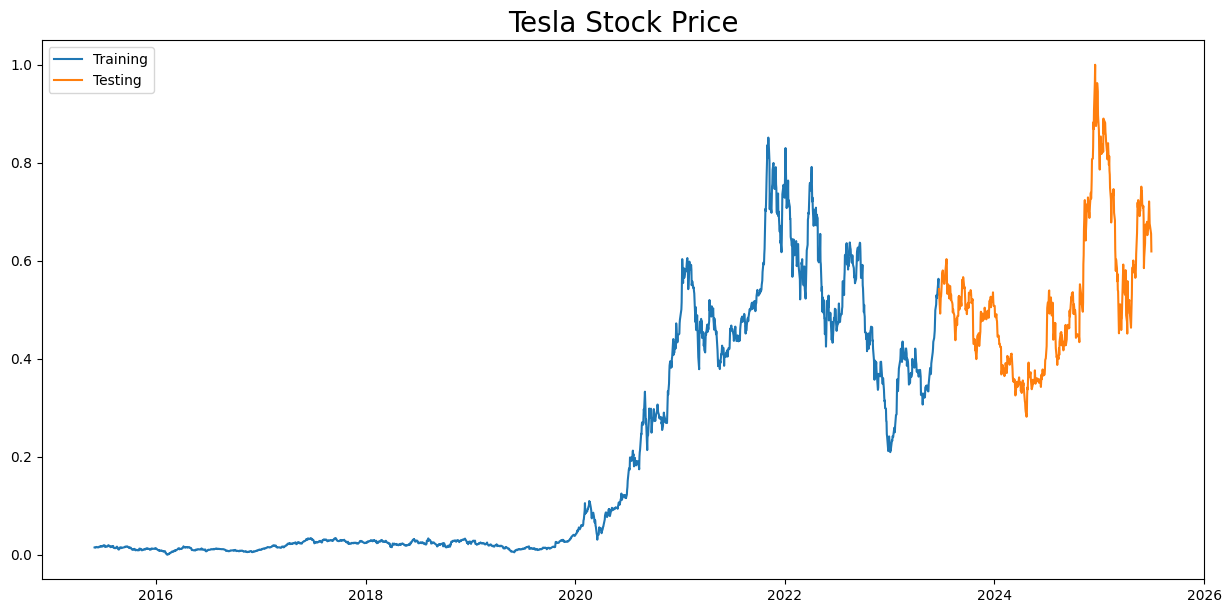

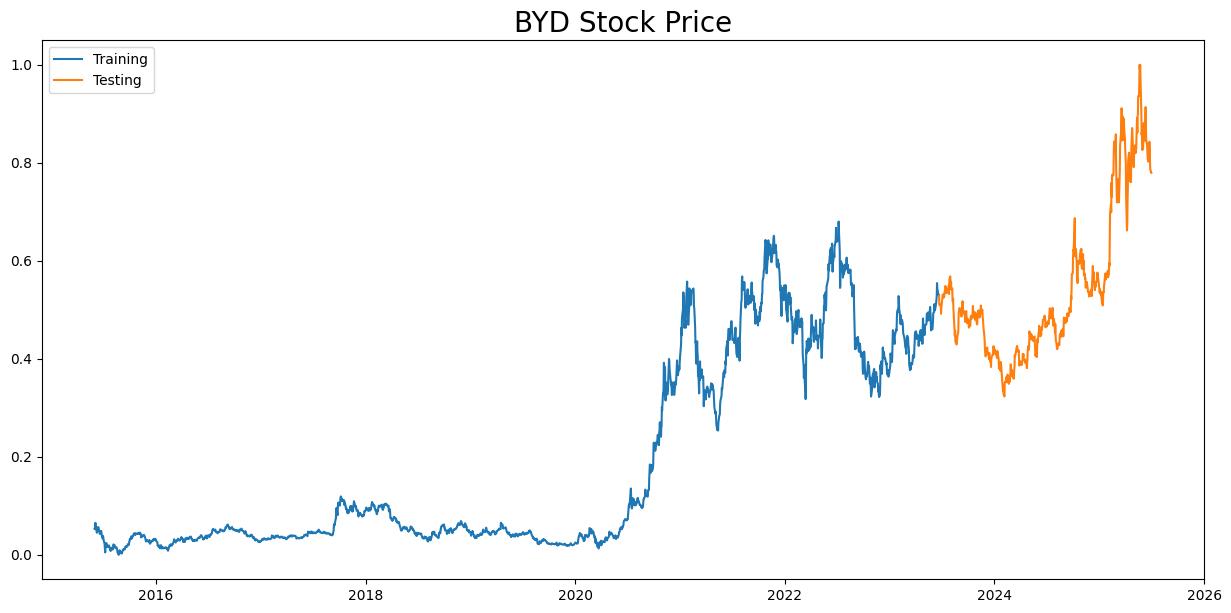

In [43]:
# Membuat grafik untuk menunjukkan perbandingan train dan test data Tesla
plt.figure(figsize=(15,7))
plt.plot(train_tesla)
plt.plot(test_tesla)
plt.legend(labels=['Training', 'Testing'])
plt.title('Tesla Stock Price', fontsize=20)
plt.show()

# Membuat grafik untuk menunjukkan perbandingan train dan test data BYD
plt.figure(figsize=(15,7))
plt.plot(train_byd)
plt.plot(test_byd)
plt.legend(labels=['Training', 'Testing'])
plt.title('BYD Stock Price', fontsize=20)
plt.show()

#### **Membagi Dataset ke Dalam Array 2 Dimensi (X dan Y)**

In [44]:
# Fungsi untuk membagi train dan test data ke dalam bentuk array X dan Y
def split_target(df, look_back=1):
    X, Y = [], []
    for i in range(len(df) - look_back):
        a = df[i:(i + look_back), 0]
        X.append(a)
        Y.append(df[i + look_back, 0])
    return np.array(X), np.array(Y)

In [45]:
# Membagi train_tesla dan test_tesla menjadi array 2 dimensi
X_train_tesla, Y_train_tesla = split_target(train_tesla.values.reshape(len(train_tesla), 1))
X_test_tesla, Y_test_tesla = split_target(test_tesla.values.reshape(len(test_tesla), 1))

In [46]:
# Mengubah bentuk train_tesla dan test_tesla menjadi array 2 dimensi
# agar dapat diproses untuk model LSTM
X_train_tesla = X_train_tesla.reshape((X_train_tesla.shape[0], 1, X_train_tesla.shape[1]))
X_test_tesla = X_test_tesla.reshape((X_test_tesla.shape[0], 1, X_test_tesla.shape[1]))

In [47]:
# Membagi train_tesla dan test_tesla menjadi array 2 dimensi
X_train_byd, Y_train_byd = split_target(train_byd.values.reshape(len(train_byd), 1))
X_test_byd, Y_test_byd = split_target(test_byd.values.reshape(len(test_byd), 1))

In [48]:
# Mengubah bentuk train_byd dan test_byd menjadi array 2 dimensi
# agar dapat diproses untuk model LSTM
X_train_byd = X_train_byd.reshape((X_train_byd.shape[0], 1, X_train_byd.shape[1]))
X_test_byd = X_test_byd.reshape((X_test_byd.shape[0], 1, X_test_byd.shape[1]))

## **4.3. Membuat Model LSTM**
Pada bagian ini, dibuat model LSTM yang nantinya akan digunakan untuk prediksi. Tahap ini juga akan dilakukan pengimplementasian algoritma dan model untuk menemukan, mengidentifikasi, dan menampilkan pola dari harga saham.

Pada bagian ini, model dipisahkan untuk data Tesla dan BYD untuk menghindari bias yang dapat terjadi.

In [49]:
drop_out = 0.2

In [50]:
# Membuat model LSTM untuk Tesla
model_tesla = Sequential([LSTM(128, input_shape=(1, 1), return_sequences=True),
                    Dropout(drop_out),
                    LSTM(64),
                    Dropout(drop_out),
                    Dense(32, activation='relu'),
                    Dense(1)])

In [51]:
# Membuat model LSTM untuk BYD
model_byd = Sequential([LSTM(128, input_shape=(1, 1), return_sequences=True),
                    Dropout(drop_out),
                    LSTM(64),
                    Dropout(drop_out),
                    Dense(32, activation='relu'),
                    Dense(1)])

In [52]:
model_tesla.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model_byd.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Menggunakan optimizer dalam proses kompilasi model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_tesla.compile(optimizer=optimizer,metrics=["mae"],loss='mse')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_byd.compile(optimizer=optimizer,metrics=["mae"],loss='mse')

In [55]:
# Menyimpan model
model_tesla.save('tesla_stock_price.keras')
model_byd.save('byd_stock_price.keras')

In [56]:
# Callbacks
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_mae') is not None and logs.get('val_mae') < 0.01:
      self.model.stop_training = True

## **4.4 Implementasi Model dan Visualisasi**
Mengimplementasikan data latih dan data uji yang telah dipisahkan ke dalam model yang telah dibuat.

### **4.4.1 Mengaplikasikan Model pada Data Tesla**

In [57]:
# Memanggil model LSTM dengan data tesla sebagai parameter
saham_tesla = model_tesla.fit(X_train_tesla,
                    Y_train_tesla,
                    epochs=150,
                    batch_size=64,
                    validation_data=(X_test_tesla, Y_test_tesla),
                    shuffle=False,
                    callbacks=[Callback()])

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0210 - mae: 0.0561 - val_loss: 0.2737 - val_mae: 0.5031
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0195 - mae: 0.0480 - val_loss: 0.2571 - val_mae: 0.4867
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0184 - mae: 0.0550 - val_loss: 0.2406 - val_mae: 0.4698
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 - mae: 0.0641 - val_loss: 0.2238 - val_mae: 0.4520
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170 - mae: 0.0735 - val_loss: 0.2066 - val_mae: 0.4330
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0168 - mae: 0.0832 - val_loss: 0.1890 - val_mae: 0.4129
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170 - mae: 0.0930 - val_loss: 0.1713 - val_mae: 0.3916
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0174 - mae: 0.1031 - val_loss: 0.1539 - val_mae: 0.3697
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss:

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


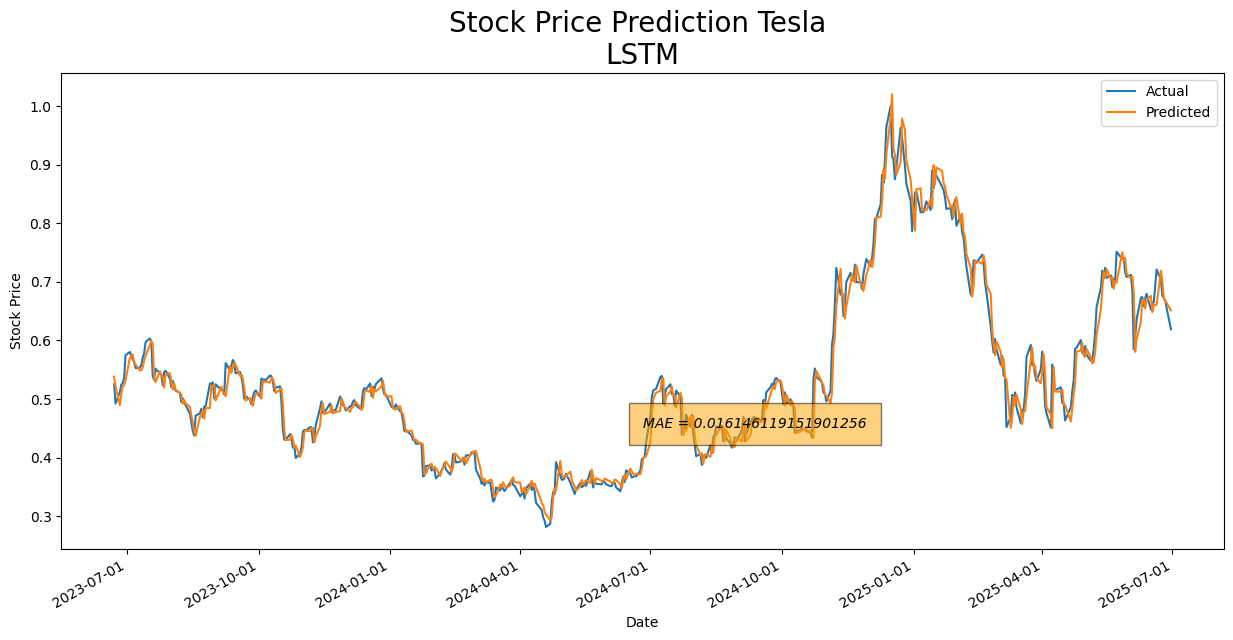

MAE:  0.016146119151901256
MSE:  0.000524667338382542
RMSE:  0.022905618052838958
MAPE:  0.03036198361656797


In [58]:
# Melakukan prediksi dengan test data
pred = model_tesla.predict(X_test_tesla)
pred_tesla = np.array(pred).reshape(-1)

# Membuat plot untuk nilai aktual dan prediksi dari saham Tesla
plt.figure(figsize=(15, 7))
plt.plot(test_tesla.index[:-1], Y_test_tesla, label='Actual')
plt.plot(test_tesla.index[:-1], pred_tesla, label='Predicted')
plt.text(test_tesla.index[len(test_tesla)//2], 0.45,
         f"MAE = {mean_absolute_error(Y_test_tesla, pred_tesla)}",
         style='italic', bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction Tesla \nLSTM', fontsize=20)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

# Evaluasi model prediksi
mae_tesla = mean_absolute_error(Y_test_tesla, pred_tesla)
mse_tesla = mean_squared_error(Y_test_tesla, pred_tesla)
rmse_tesla = np.sqrt(mean_squared_error(Y_test_tesla, pred_tesla))
mape_tesla = mean_absolute_percentage_error(Y_test_tesla, pred_tesla)
print('MAE: ', mae_tesla)
print('MSE: ', mse_tesla)
print('RMSE: ', rmse_tesla)
print('MAPE: ', mape_tesla)

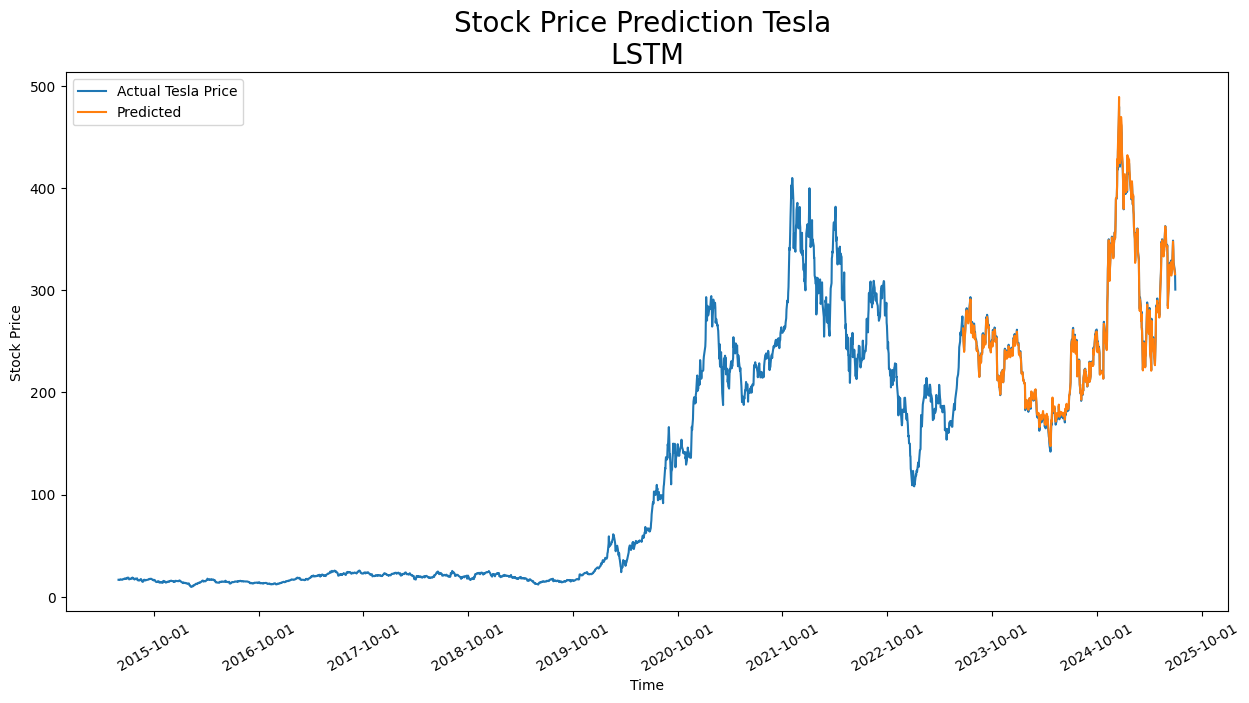

In [59]:
# Menampilkan grafik harga saham penutupan perusahaan Tesla
# Membuat array temporer dengan 2 kolom, kolom pertama diisi dengan prediksi saham Tesla.
temp_array = np.zeros((np.array(pred_tesla).reshape(-1, 1).shape[0], 2))
temp_array[:, 0] = np.array(pred_tesla).reshape(-1, 1)[:, 0]

# Melakukan tranformasi inverse pada array sementara
y_pred_original = scale_tesla.inverse_transform(temp_array)

# Mengekstrak prediksi dari Tesla
y_pred_original = y_pred_original[:, 0]

# Membuat plot untuk nilai aktual dan prediksi dari saham Tesla
plt.figure(figsize=(15, 7))
plt.plot(df_3.index, df_3['Tesla'], label='Actual Tesla Price')
plt.plot(test_tesla.index[:-1], y_pred_original,label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction Tesla \nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))

# Merotasi x-axis labels
plt.xticks(rotation=30)

plt.legend()
plt.show()

### **4.4.2 Mengaplikasikan Model pada Data BYD**

In [60]:
# Memanggil model LSTM dengan data tesla sebagai parameter
saham_byd = model_byd.fit(X_train_byd,
                    Y_train_byd,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_test_byd, Y_test_byd),
                    shuffle=False,
                    callbacks=[Callback()])

Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0141 - mae: 0.0607 - val_loss: 0.2559 - val_mae: 0.4828
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0110 - mae: 0.0493 - val_loss: 0.2130 - val_mae: 0.4374
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0111 - mae: 0.0717 - val_loss: 0.1738 - val_mae: 0.3916
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0131 - mae: 0.0960 - val_loss: 0.1401 - val_mae: 0.3483
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0159 - mae: 0.1158 - val_loss: 0.1137 - val_mae: 0.3106
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0184 - mae: 0.1290 - val_loss: 0.0937 - val_mae: 0.2797
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0198 - mae: 0.1356 - val_loss: 0.0780 - val_mae: 0.2535
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0198 - mae: 0.1368 - val_loss: 0.0647 - val_mae: 0.2297
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.01

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


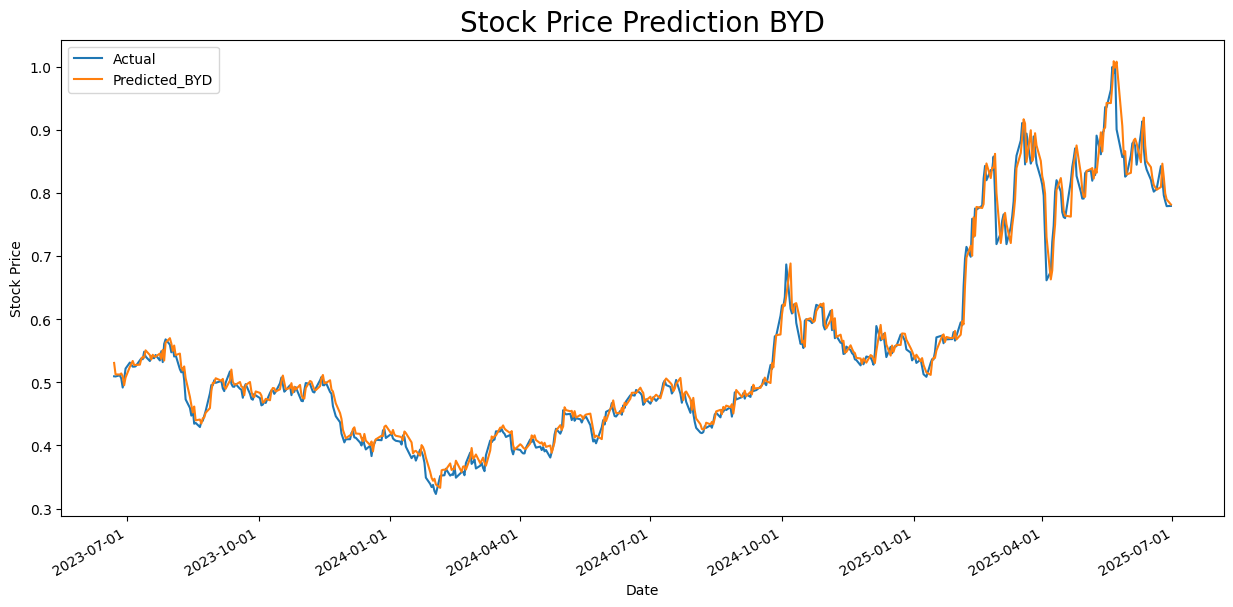

MAE:  0.013262574900132955
MSE:  0.0003518926091319775
RMSE:  0.018758800844722926
MAPE:  0.02373105890869859


In [61]:
# Melakukan prediksi dengan test data
pred = model_byd.predict(X_test_byd)
pred_byd = np.array(pred).reshape(-1)

# Membuat plot untuk nilai aktual dan prediksi dari saham byd
plt.figure(figsize=(15, 7))
plt.plot(test_byd.index[:-1], Y_test_byd, label='Actual')
plt.plot(test_byd.index[:-1], pred_byd, label='Predicted_BYD')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction BYD', fontsize=20)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

# Evaluasi model prediksi dengan batch size 150 dan epoch 32
mae_byd = mean_absolute_error(Y_test_byd, pred_byd)
mse_byd = mean_squared_error(Y_test_byd, pred_byd)
rmse_byd = np.sqrt(mean_squared_error(Y_test_byd, pred_byd))
mape_byd = mean_absolute_percentage_error(Y_test_byd, pred_byd)
print('MAE: ', mae_byd)
print('MSE: ', mse_byd)
print('RMSE: ', rmse_byd)
print('MAPE: ', mape_byd)

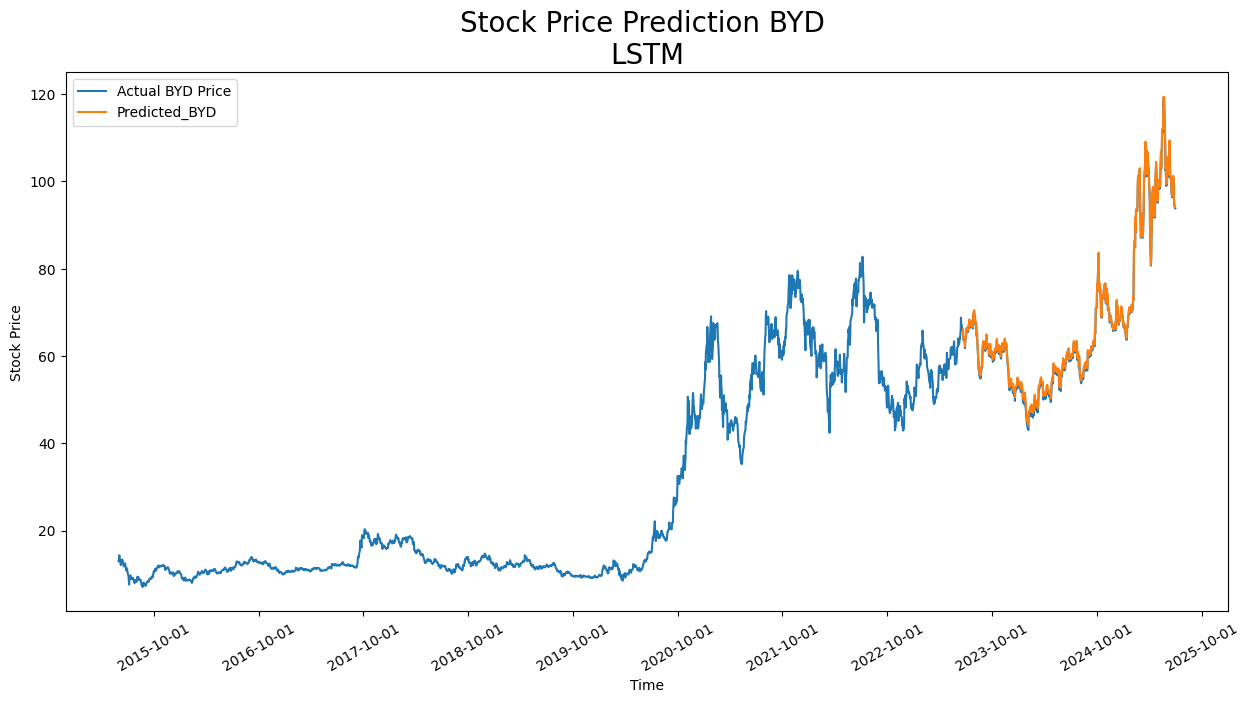

In [62]:
# Menampilkan grafik harga saham penutupan perusahaan BYD
# Membuat array temporer dengan 2 kolom, kolom pertama diisi dengan prediksi saham BYD.
temp_array_byd = np.zeros((pred_byd.shape[0], 2))
temp_array_byd[:, 0] = 0
temp_array_byd[:, 1] = pred_byd

# Melakukan tranformasi inverse pada array sementara
y_pred_original = scale_byd.inverse_transform(temp_array_byd)

# Mengekstrak prediksi dari byd
y_pred_original = y_pred_original[:, 1]

# Membuat plot untuk nilai aktual dan prediksi dari saham byd
plt.figure(figsize=(15, 7))
plt.plot(df_3.index, df_3['BYD'], label='Actual BYD Price')
plt.plot(test_byd.index[:-1], y_pred_original, label='Predicted_BYD')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction BYD \nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))

# Merotasi x-axis labels
plt.xticks(rotation=30)

plt.legend()
plt.show()

# **5. EVALUATION**


Bagian ini adalah bagian untuk menilai/mengevaluasi model yang telah digunakan serta mengukur tingkat akurasi model.

### **Evaluasi Model LSTM**

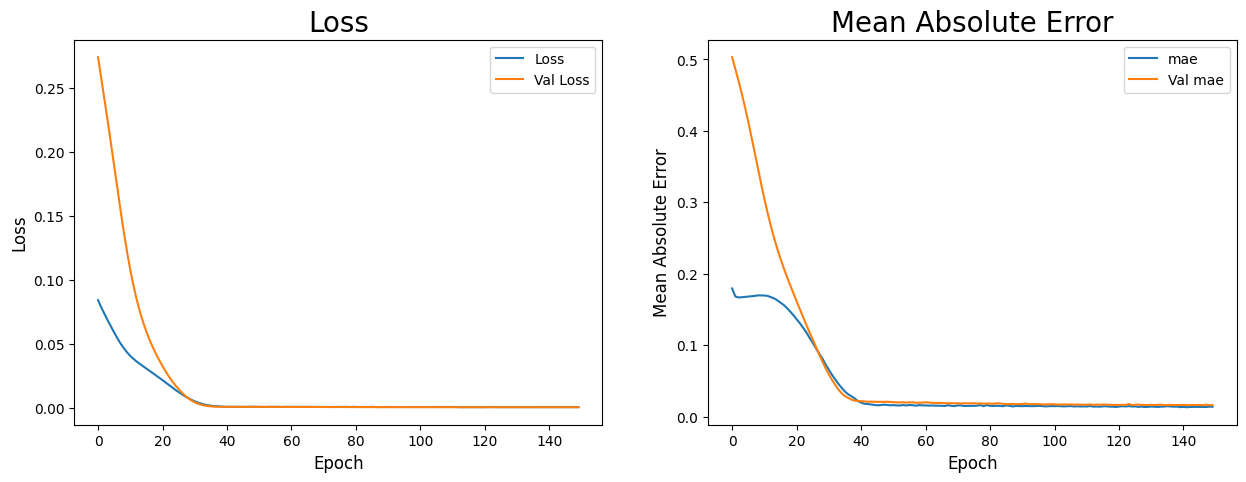

In [63]:
# Membuat grafik untuk menunjukkan nilai Loss dan MAER dari model 'saham_tesla'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(saham_tesla.history['loss'])
ax1.plot(saham_tesla.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(saham_tesla.history['mae'])
ax2.plot(saham_tesla.history['val_mae'])
ax2.legend(['mae','Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()

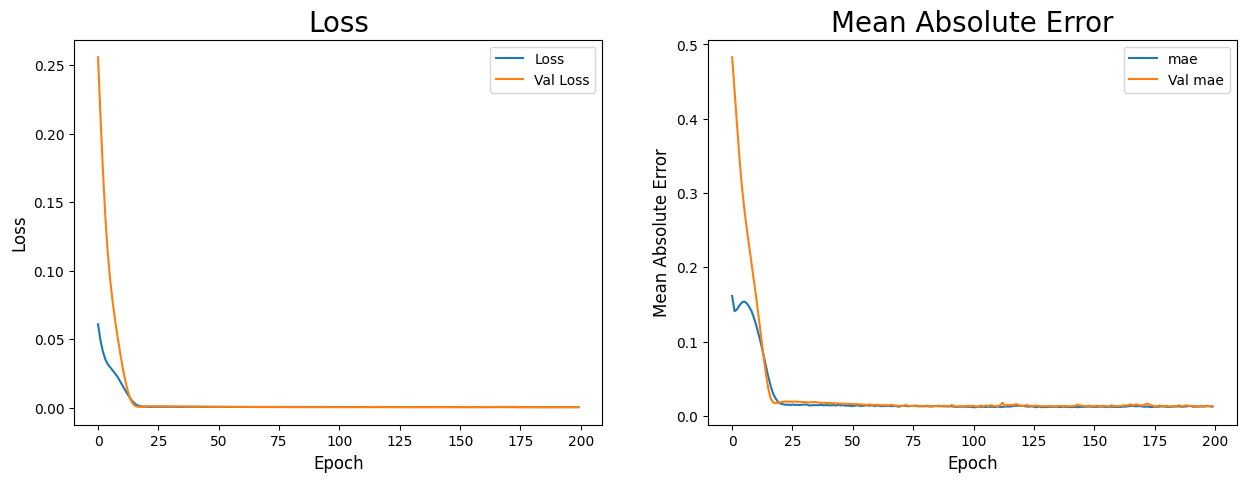

In [64]:
# Membuat grafik untuk menunjukkan nilai Loss dan MAER dari model 'saham_byd'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(saham_byd.history['loss'])
ax1.plot(saham_byd.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(saham_byd.history['mae'])
ax2.plot(saham_byd.history['val_mae'])
ax2.legend(['mae','Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()

In [65]:
# Evaluasi model prediksi Tesla
mae_tesla = mean_absolute_error(Y_test_tesla, pred_tesla)
mse_tesla = mean_squared_error(Y_test_tesla, pred_tesla)
rmse_tesla = np.sqrt(mean_squared_error(Y_test_tesla, pred_tesla))
mape_tesla = mean_absolute_percentage_error(Y_test_tesla, pred_tesla)
print('MAE: ', mae_tesla)
print('MSE: ', mse_tesla)
print('RMSE: ', rmse_tesla)
print('MAPE: ', mape_tesla)

MAE:  0.016146119151901256
MSE:  0.000524667338382542
RMSE:  0.022905618052838958
MAPE:  0.03036198361656797


In [66]:
# Evaluasi model prediksi BYD
mae_byd = mean_absolute_error(Y_test_byd, pred_byd)
mse_byd = mean_squared_error(Y_test_byd, pred_byd)
rmse_byd = np.sqrt(mean_squared_error(Y_test_byd, pred_byd))
mape_byd = mean_absolute_percentage_error(Y_test_byd, pred_byd)
print('MAE: ', mae_byd)
print('MSE: ', mse_byd)
print('RMSE: ', rmse_byd)
print('MAPE: ', mape_byd)

MAE:  0.013262574900132955
MSE:  0.0003518926091319775
RMSE:  0.018758800844722926
MAPE:  0.02373105890869859


# **6. PREDICTING**


Setelah dilakukan uji validitas dari model yang akan digunakan pada data latih terhadap data uji, selanjutnya dilakukan prediksi dari data yang ada untuk mengetahui potensi harga dari kedua perusahaan.

### **6.1. Prediksi Satu Hari Kedepan**

In [67]:
df_pred = pd.DataFrame()
def one_day(data, model, scaler, company):
  global df_pred
  last_data = data.values[-1].reshape(-1, 1)
  last_data = last_data.reshape((1, 1, 1))
  predicted_scaled = model.predict(last_data)
  predicted_close = scaler.inverse_transform(predicted_scaled)
  predicted_date = pd.Timestamp(datetime.today().strftime('%Y-%m-%d')) + pd.Timedelta(days=1)
  print(f"Prediksi harga saham {company} untuk {predicted_date} adalah: $ {predicted_close[0][0]:.2f}")

  #if predicted_date in df_pred.index:
  #  df_pred.loc[predicted_date, f'Prediction {company}'] = predicted_close[0][0]
  #else:
  #  new_row = pd.DataFrame({f'Prediction {company}': predicted_close[0][0]}, index=[predicted_date])
  #  df_pred = pd.concat([df_pred, new_row])


  return predicted_close[0][0]

In [68]:
predict_close_tesla = one_day(df_3['scaled_tesla'], model_tesla, scale_tesla, 'Tesla')
predict_close_byd = one_day(df_3['scaled_byd'], model_byd, scale_byd, 'BYD')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediksi harga saham Tesla untuk 2025-07-03 00:00:00 adalah: $ 298.60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediksi harga saham BYD untuk 2025-07-03 00:00:00 adalah: $ 94.13


### **6.2. Prediksi Saham 60 Hari Ke Depan**

In [69]:
  # Membuat range tanggal untuk 60 hari ke depan
def future_days(data, model, scaler, company, period):
    global df_future
    last_date = df_3.index[-1]
    all_future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=period)

    future_dates = all_future_dates[all_future_dates.weekday < 5]
    future_dates = future_dates[:period]
    week_days = len(future_dates)

    # Menyiapkan data untuk prediksi
    future_pred = []
    last_data= data.values[-1].reshape(-1, 1)
    last_data = last_data.reshape((1, 1, 1))

    for _ in range(week_days):
        predicted_scaled = model.predict(last_data)
        predicted_close = scaler.inverse_transform(predicted_scaled)
        future_pred.append(predicted_close[0][0])
        last_data = predicted_scaled.reshape((1, 1, 1))

    df_future = pd.DataFrame({f'Prediction {company}': future_pred}, index=future_dates)

    return df_future

In [70]:
predict_60_tesla = future_days(df_3['scaled_tesla'], model_tesla, scale_tesla, 'Tesla', 60)
predict_60_byd = future_days(df_3['scaled_byd'], model_byd, scale_byd, 'BYD', 60)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

In [71]:
# Mencetak Hasil Prediksi 60 Hari
predict_60_tesla

,Prediction Tesla
2025-07-02,298.603149
2025-07-03,296.482452
2025-07-04,294.350739
2025-07-07,292.211121
2025-07-08,290.066528
2025-07-09,287.920074
2025-07-10,285.774811
2025-07-11,283.633911
2025-07-14,281.500397
2025-07-15,279.377411


In [72]:
# Mencetak hasil prediksi 60 hari
predict_60_byd

,Prediction BYD
2025-07-02,94.127861
2025-07-03,94.420670
2025-07-04,94.718605
2025-07-07,95.021835
2025-07-08,95.330582
2025-07-09,95.645035
2025-07-10,95.965416
2025-07-11,96.291931
2025-07-14,96.624825
2025-07-15,96.964333


In [73]:
# Menggabungkan hasil prediksi Tesla dan BYD
df_predict_60 = pd.concat([predict_60_tesla, predict_60_byd], axis=1)
print(df_predict_60)

            Prediction Tesla  Prediction BYD
2025-07-02        298.603149       94.127861
2025-07-03        296.482452       94.420670
2025-07-04        294.350739       94.718605
2025-07-07        292.211121       95.021835
2025-07-08        290.066528       95.330582
2025-07-09        287.920074       95.645035
2025-07-10        285.774811       95.965416
2025-07-11        283.633911       96.291931
2025-07-14        281.500397       96.624825
2025-07-15        279.377411       96.964333
2025-07-16        277.267853       97.310707
2025-07-17        275.174683       97.664223
2025-07-18        273.100800       98.025146
2025-07-21        271.048981       98.393784
2025-07-22        269.021790       98.770439
2025-07-23        267.021790       99.155434
2025-07-24        265.051361       99.549088
2025-07-25        263.112732       99.951767
2025-07-28        261.207977      100.363853
2025-07-29        259.338989      100.785736
2025-07-30        257.507568      101.217834
2025-07-31

### **ALTERNATIF PREDIKSI**

### **6.2 Prediksi 60 Hari**

In [74]:
# Membuat range tanggal untuk 60 hari ke depan
last_date = df_3.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=60)

# Menyiapkan data untuk prediksi
future_pred_tesla = []
last_data_tesla = df_3['scaled_tesla'].values[-1].reshape(-1, 1)
last_data_tesla = last_data_tesla.reshape((1, 1, 1))

for _ in range(60):
    predicted_scaled_tesla = model_tesla.predict(last_data_tesla)
    predicted_close = scale_tesla.inverse_transform(predicted_scaled_tesla)
    future_pred_tesla.append(predicted_close[0][0])
    last_data_tesla = predicted_scaled_tesla.reshape((1, 1, 1))

# Create a DataFrame for future predictions
df_60_tesla = pd.DataFrame({'Prediction Tesla': future_pred_tesla}, index=future_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━

In [75]:
# Mencetak tabel hasil prediksi saham Tesla
df_60_tesla

,Prediction Tesla
2025-07-02,298.603149
2025-07-03,296.482452
2025-07-04,294.350739
2025-07-05,292.211121
2025-07-06,290.066528
2025-07-07,287.920074
2025-07-08,285.774811
2025-07-09,283.633911
2025-07-10,281.500397
2025-07-11,279.377411


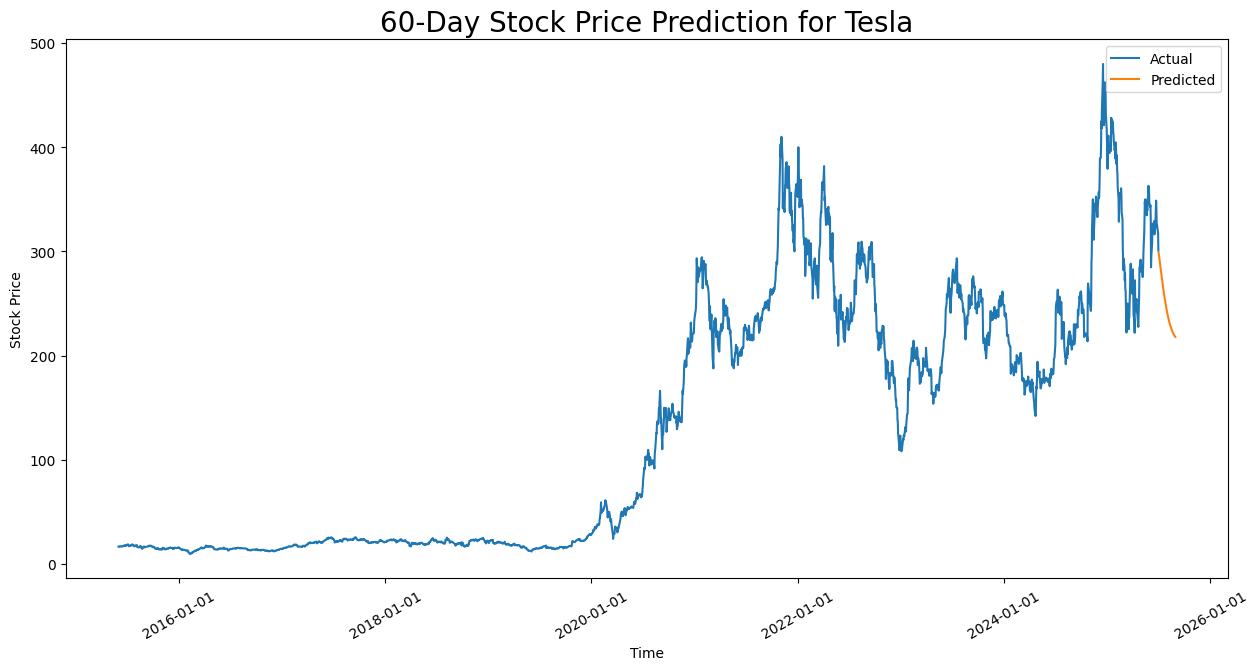

In [76]:
# Menggabungkan data hasil prediksi 'df_60_tesla' dengan dataset 'df_3'
df_extended = pd.concat([df_3, df_60_tesla])

# Melakukan visualisasi dari prediksi
plt.figure(figsize=(15, 7))
plt.plot(df_3.index, df_3['Tesla'], label='Actual')
plt.plot(df_60_tesla['Prediction Tesla'], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('60-Day Stock Price Prediction for Tesla', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) #use auto locator for better date display
plt.xticks(rotation=30)
plt.legend()
plt.show()

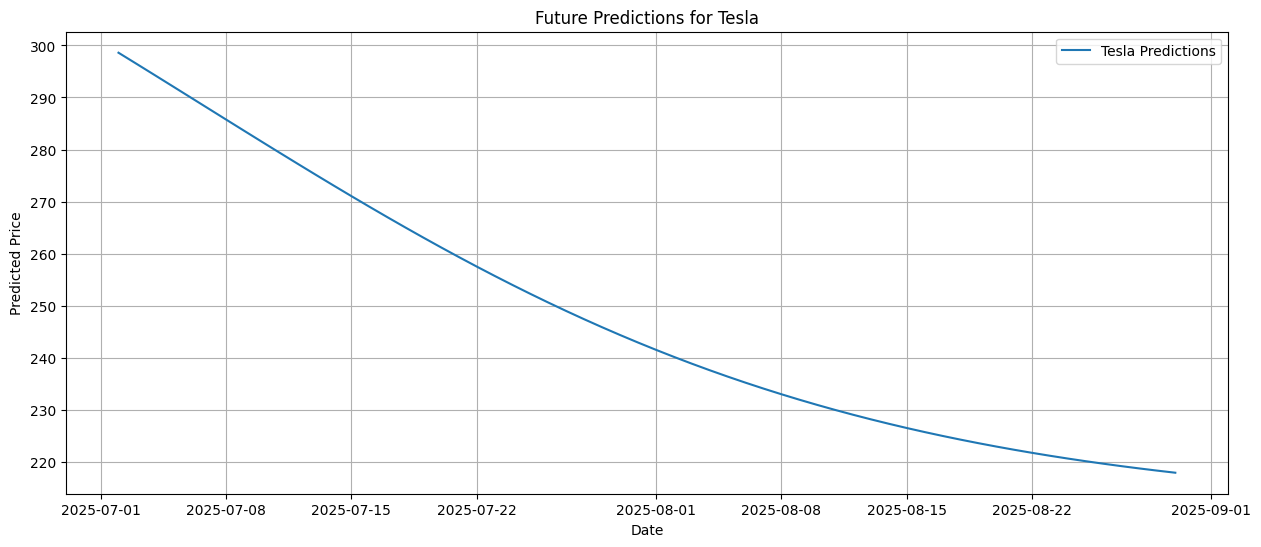

In [77]:
plt.figure(figsize=(15, 6))
plt.plot(df_60_tesla.index, df_60_tesla['Prediction Tesla'], label='Tesla Predictions')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.title('Future Predictions for Tesla')
plt.legend()
plt.grid(True)
plt.show()

#### **Prediksi 60 Hari Harga Saham BYD**

In [78]:
# Membuat range tanggal untuk 60 hari ke depan
last_date = df_3.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=60)

# Menyiapkan data untuk prediksi
future_pred_byd = []
last_data_byd = df_3['scaled_byd'].values[-1].reshape(-1, 1)
last_data_byd = last_data_byd.reshape((1, 1, 1))

for _ in range(60):
    # Predict the next day's scaled price
    predicted_close_scaled = model_byd.predict(last_data_byd)

    # Inverse transform to get the original price scale
    predicted_close = scale_byd.inverse_transform(predicted_close_scaled)
    future_pred_byd.append(predicted_close[0][0])

    # Update last_data with the predicted value for the next iteration
    last_data_byd = predicted_close_scaled.reshape((1, 1, 1))


# Create a DataFrame for future predictions
df_60_byd = pd.DataFrame({'Prediction BYD': future_pred_byd}, index=future_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

In [79]:
# Mencetak tabel hasil prediksi saham BYD
df_60_byd

,Prediction BYD
2025-07-02,94.127861
2025-07-03,94.420670
2025-07-04,94.718605
2025-07-05,95.021835
2025-07-06,95.330582
2025-07-07,95.645035
2025-07-08,95.965416
2025-07-09,96.291931
2025-07-10,96.624825
2025-07-11,96.964333


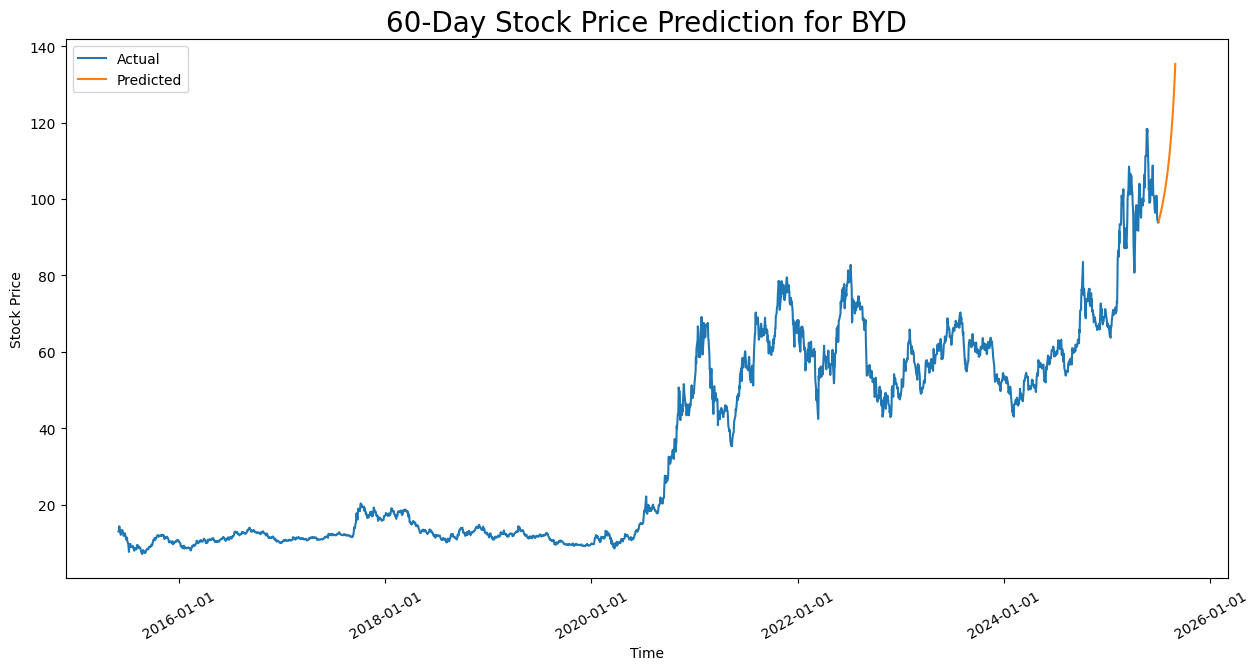

In [80]:
# Menggabungkan data hasil prediksi 'df_60_byd' dengan dataset 'df_3'
df_extended = pd.concat([df_3, df_60_byd])

# Melakukan visualisasi dari prediksi
plt.figure(figsize=(15, 7))
plt.plot(df_3.index, df_3['BYD'], label='Actual')
plt.plot(df_60_byd['Prediction BYD'], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('60-Day Stock Price Prediction for BYD', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) #use auto locator for better date display
plt.xticks(rotation=30)
plt.legend()
plt.show()

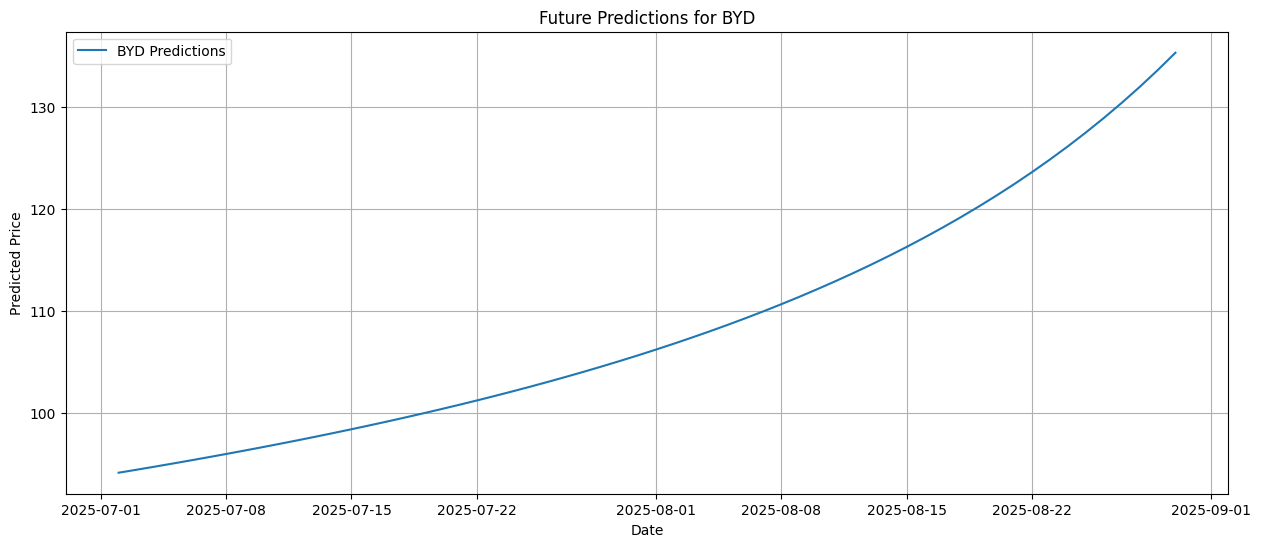

In [81]:
plt.figure(figsize=(15, 6))
plt.plot(df_60_byd.index, df_60_byd['Prediction BYD'], label='BYD Predictions')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.title('Future Predictions for BYD')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
df_pred_60 = pd.concat([df_60_tesla, df_60_byd], axis=1)
print(df_pred_60)

            Prediction Tesla  Prediction BYD
2025-07-02        298.603149       94.127861
2025-07-03        296.482452       94.420670
2025-07-04        294.350739       94.718605
2025-07-05        292.211121       95.021835
2025-07-06        290.066528       95.330582
2025-07-07        287.920074       95.645035
2025-07-08        285.774811       95.965416
2025-07-09        283.633911       96.291931
2025-07-10        281.500397       96.624825
2025-07-11        279.377411       96.964333
2025-07-12        277.267853       97.310707
2025-07-13        275.174683       97.664223
2025-07-14        273.100800       98.025146
2025-07-15        271.048981       98.393784
2025-07-16        269.021790       98.770439
2025-07-17        267.021790       99.155434
2025-07-18        265.051361       99.549088
2025-07-19        263.112732       99.951767
2025-07-20        261.207977      100.363853
2025-07-21        259.338989      100.785736
2025-07-22        257.507568      101.217834
2025-07-23

### **6.3. Prediksi 100 Hari**

In [83]:
predict_100_tesla = future_days(df_3['scaled_tesla'], model_tesla, scale_tesla, 'Tesla', 100)
predict_100_byd = future_days(df_3['scaled_byd'], model_byd, scale_byd, 'BYD', 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

In [84]:
print(f'Prediksi Saham Tesla 100 Hari:\n {predict_100_tesla}')
print(f'Prediksi Saham BYD 100 Hari:\n {predict_100_byd}')

Prediksi Saham Tesla 100 Hari:
             Prediction Tesla
2025-07-02        298.603149
2025-07-03        296.482452
2025-07-04        294.350739
2025-07-07        292.211121
2025-07-08        290.066528
...                      ...
2025-10-03        215.336182
2025-10-06        215.085220
2025-10-07        214.847137
2025-10-08        214.621307
2025-10-09        214.407135

[72 rows x 1 columns]
Prediksi Saham BYD 100 Hari:
             Prediction BYD
2025-07-02       94.127861
2025-07-03       94.420670
2025-07-04       94.718605
2025-07-07       95.021835
2025-07-08       95.330582
...                    ...
2025-10-03      153.063751
2025-10-06      155.915344
2025-10-07      158.948517
2025-10-08      162.178513
2025-10-09      165.621918

[72 rows x 1 columns]


In [85]:
# Mencetak Hasil Prediksi Harga Saham 100 Hari
predict_100_tesla

,Prediction Tesla
2025-07-02,298.603149
2025-07-03,296.482452
2025-07-04,294.350739
2025-07-07,292.211121
2025-07-08,290.066528
...,...
2025-10-03,215.336182
2025-10-06,215.085220
2025-10-07,214.847137
2025-10-08,214.621307


In [86]:
# Mencetak Hasil Prediksi Harga Saham 100 Hari
predict_100_byd

,Prediction BYD
2025-07-02,94.127861
2025-07-03,94.420670
2025-07-04,94.718605
2025-07-07,95.021835
2025-07-08,95.330582
...,...
2025-10-03,153.063751
2025-10-06,155.915344
2025-10-07,158.948517
2025-10-08,162.178513


In [87]:
df_predict_100 = pd.concat([predict_100_tesla, predict_100_byd], axis=1)
print(df_predict_100)

            Prediction Tesla  Prediction BYD
2025-07-02        298.603149       94.127861
2025-07-03        296.482452       94.420670
2025-07-04        294.350739       94.718605
2025-07-07        292.211121       95.021835
2025-07-08        290.066528       95.330582
...                      ...             ...
2025-10-03        215.336182      153.063751
2025-10-06        215.085220      155.915344
2025-10-07        214.847137      158.948517
2025-10-08        214.621307      162.178513
2025-10-09        214.407135      165.621918

[72 rows x 2 columns]


In [88]:
# @title
def days_until_input(input_date_str):
  try:
    input_date = datetime.strptime(input_date_str, '%Y-%m-%d').date()
    last_date = df_3.index[-1].date()
    delta = input_date - last_date
    return delta.days
  except ValueError:
    print("Format tanggal harus YYYY-MM-DD")
    return None

# Hanya dapat memproses tanggal yang lebih dari tanggal hari ini
input_date = input("Masukkan tanggal dengan format YYYY-MM-DD :")
# Memeriksa apakah tanggal sudah ada dalam prediksi yang dibuat
if input_date in df_predict_100.index:
  days = 0
  print(df_predict_100[df_predict_100.index==input_date])
else:
  days = days_until_input(input_date)

  # Jika prediksi untuk tanggal tersebut belum tersedia maka akan dilakukan pemanggilan model
  # untuk memprediksi harga saham hingga tanggal tersebut
  pred_random_tesla = future_days(df_3[f'scaled_tesla'], model_tesla, scale_tesla, 'Tesla', days)
  pred_random_byd = future_days(df_3[f'scaled_byd'], model_byd, scale_byd, 'BYD', days)

  print(f'Prediksi Harga Saham pada tanggal {input_date} adalah ')
  print('Tesla: ', pred_random_tesla.values[-1], 'BYD: ', pred_random_byd.values[-1])

Masukkan tanggal dengan format YYYY-MM-DD :2025-07-07
            Prediction Tesla  Prediction BYD
2025-07-07        292.211121       95.021835


# **7. VISUALISASI**


Bagian ini adalah bagian untuk menilai/mengevaluasi model yang telah digunakan serta mengukur tingkat akurasi model.

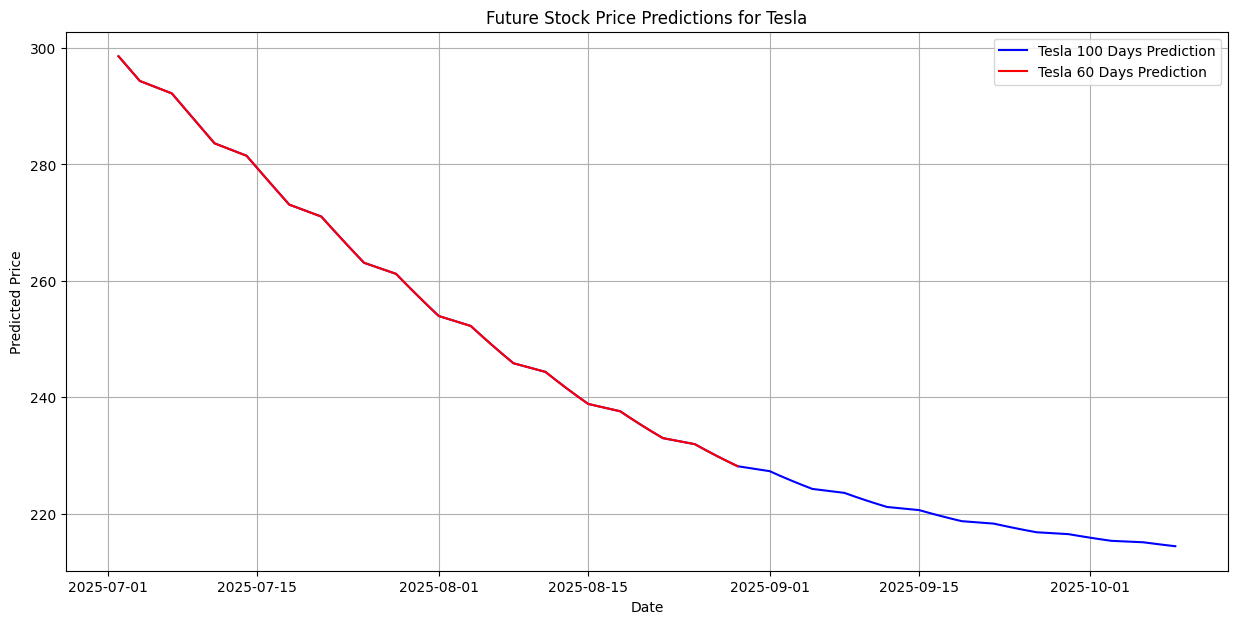

In [89]:
# Visualisasi
plt.figure(figsize=(15, 7))
plt.plot(df_predict_100.index, df_predict_100['Prediction Tesla'], color='Blue', label= 'Tesla 100 Days Prediction')
plt.plot(predict_60_tesla.index, predict_60_tesla['Prediction Tesla'], color='Red', label='Tesla 60 Days Prediction')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.title('Future Stock Price Predictions for Tesla')
plt.legend()
plt.grid(True)
plt.show()

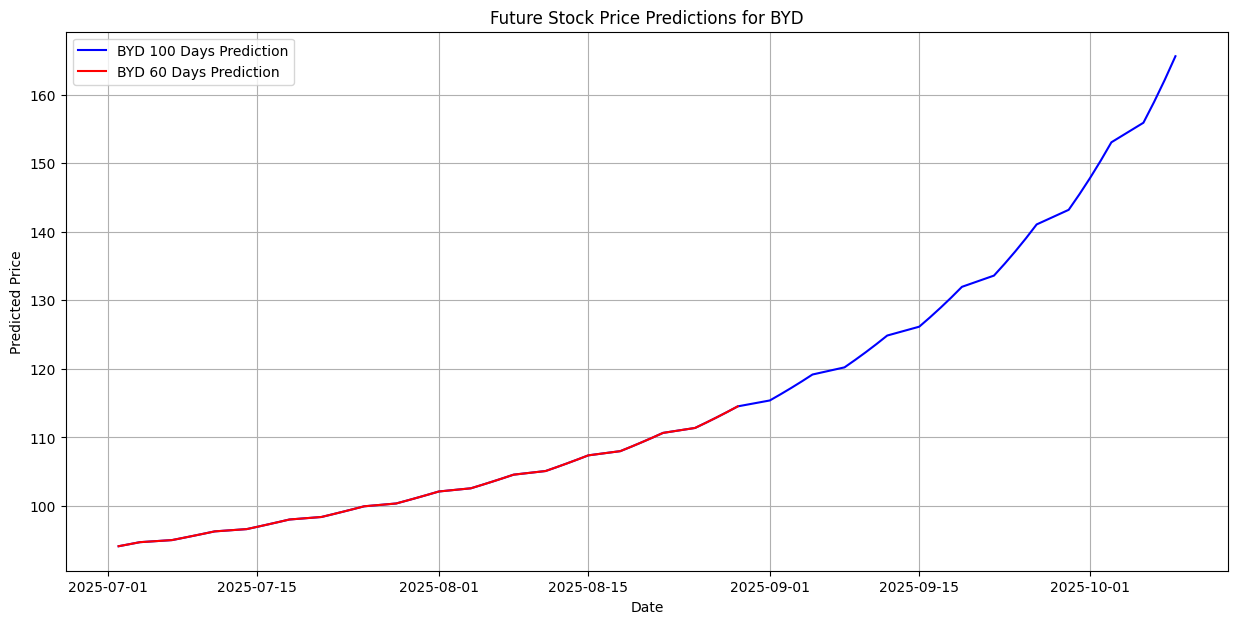

In [90]:
# Visualisasi
plt.figure(figsize=(15, 7))
plt.plot(df_predict_100.index, df_predict_100['Prediction BYD'], color='Blue', label= 'BYD 100 Days Prediction')
plt.plot(predict_60_byd.index, predict_60_byd['Prediction BYD'], color='Red', label='BYD 60 Days Prediction')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.title('Future Stock Price Predictions for BYD')
plt.legend()
plt.grid(True)
plt.show()

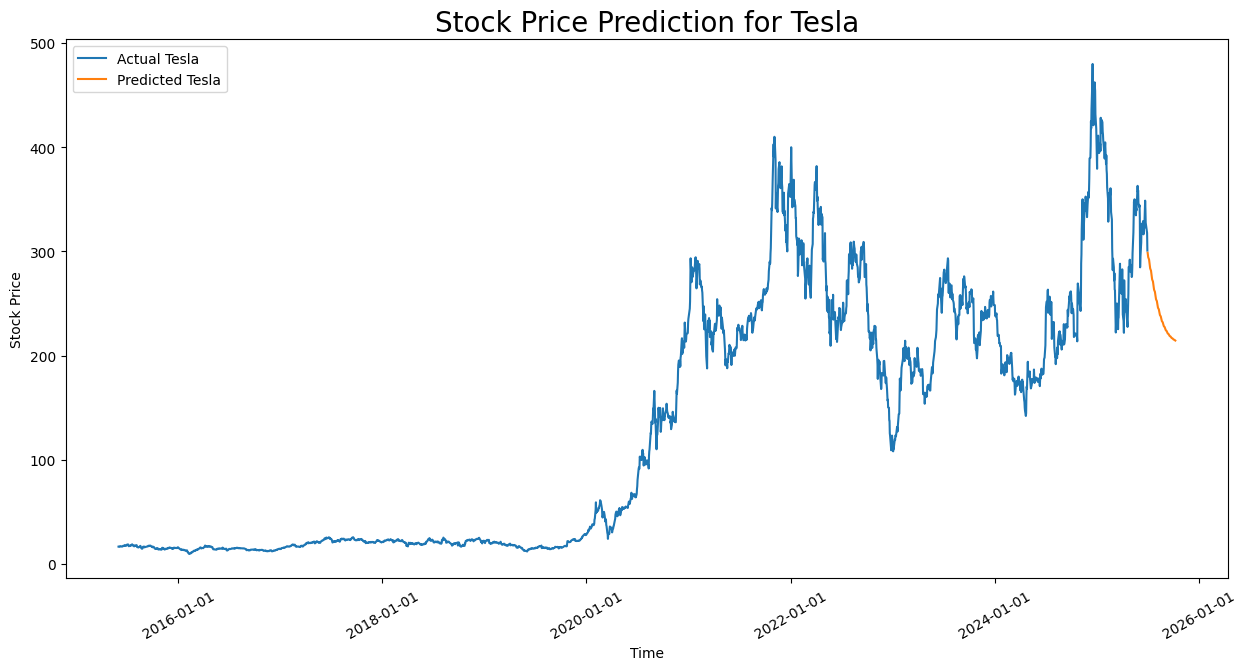

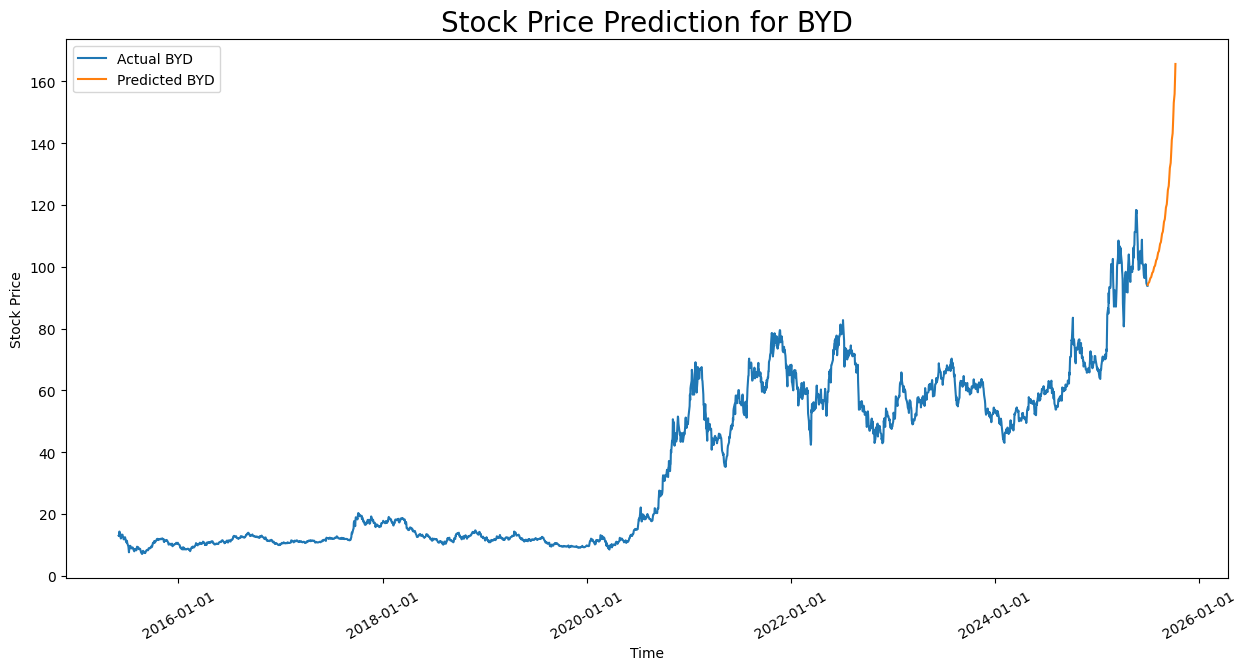

In [91]:
# Menggabungkan data hasil prediksi dengan dataset 'df_3'
df_extended = pd.concat([df_3, df_predict_100])

# Melakukan visualisasi dari prediksi
plt.figure(figsize=(15, 7))
plt.plot(df_3.index, df_3['Tesla'], label='Actual Tesla')
plt.plot(df_predict_100['Prediction Tesla'], label='Predicted Tesla')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction for Tesla', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) #use auto locator for better date display
plt.xticks(rotation=30)
plt.legend()
plt.show()

# Melakukan visualisasi dari prediksi
plt.figure(figsize=(15, 7))
plt.plot(df_3.index, df_3['BYD'], label='Actual BYD')
plt.plot(df_predict_100['Prediction BYD'], label='Predicted BYD')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction for BYD', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) #use auto locator for better date display
plt.xticks(rotation=30)
plt.legend()
plt.show()

In [92]:
# save df_predict_100 and df_pred_60 to excel
df_combined = pd.concat([df_predict_100, df_predict_60], axis=1)
df_combined

df_combined.to_excel('df_predictiction.xlsx')